In [282]:
# IMPORT LIBRARIES #
import pandas as pd
import pygsheets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [283]:
# FLAGS #

#Set to 1 to print diagnostic info
debugFlag = 0
#Set to 1 to pull info from RawNames sheet, join GPS, update, and export
updateGPSFlag = 0

In [284]:
# IMPORT DATA #

gc = pygsheets.authorize(service_file='file.json')
sh = gc.open('DashData')

if debugFlag:
    for x in sh:
        print(x)

for x in sh:
    title = x.title
    if(title=="DeliveriesOld"):
        import_sheets_OldDelDF = x.get_as_df()
    elif(title=="Deliveries"):
        import_sheets_DelDF = x.get_as_df()
    elif(title=="Days"):
        import_sheets_DaysDF = x.get_as_df()
    elif(title=="Weeks"):
        import_sheets_WeeksDF = x.get_as_df()
    elif(title=="RawNames"):
        import_sheets_RawNamesDF = x.get_as_df()
    elif(title=="GPS"):
        #for import
        import_sheets_GPSDF = x.get_as_df()
        #for export
        if updateGPSFlag:
            import_wks_gps = x
    else:
        print("Worksheet not stored: ", x)

Worksheet not stored:  <Worksheet 'Import' index:6>
Worksheet not stored:  <Worksheet 'Lifetime Deliveries' index:7>
Worksheet not stored:  <Worksheet 'Days Old' index:8>
Worksheet not stored:  <Worksheet 'Weeks Old' index:9>


In [285]:
# Allows for disjoint cells, one for import, one for reset to import value (for ease of testing)

#DF from sheets
sheets_OldDelDF   = import_sheets_OldDelDF.copy()
sheets_DelDF      = import_sheets_DelDF.copy()
sheets_DaysDF     = import_sheets_DaysDF.copy()
sheets_WeeksDF    = import_sheets_WeeksDF.copy()
sheets_RawNamesDF = import_sheets_RawNamesDF.copy()
sheets_GPSDF      = import_sheets_GPSDF.copy()

In [286]:
# FUNCTIONS #

#Used only for delivery data
def processStacks(df):
    df["Stack Encoding"] = 0 
    for index, row in df.iterrows():
        if type(row["Stacked"]) == int:
            df.at[index, "Stack Encoding"] = 2
            df.at[index, "Distance"] /= 2
            df.at[index, "Duration"] /= 2
        else:
            if (row["Stacked"] == ""):
                df.at[index, "Stack Encoding"] = 1
            elif (row["Stacked"] == "PENTA"):
                df.at[index, "Stack Encoding"] = 5
                df.at[index, "Distance"] /= 5
                df.at[index, "Duration"] /= 5
            elif (row["Stacked"] == "QUAD"):
                df.at[index, "Stack Encoding"] = 4
                df.at[index, "Distance"] /= 4
                df.at[index, "Duration"] /= 4
            else:
                df.at[index, "Stack Encoding"] = 3
                df.at[index, "Distance"] /= 3
                df.at[index, "Duration"] /= 3

#Used to convert $#.## strings to float values
def dollars_to_floats(df, columns):
    for x in columns:
        df[x] = df[x].str.replace('$', '')
        df[x] = df[x].str.replace(',', '')
        df[x] = df[x].astype(float)

#Used to convert hh:mm strings to float values        
def hours_to_floats(df, columns):
    for x in columns:
        for index, row in df.iterrows():
            active = row[x]
            activeH = float(active[:active.index(":")])
            activeM = round(float(active[active.index(":")+1:active.index(":")+3])/60, 2)
            active = activeH + activeM
            df.at[index, x] = active
        df[x] = df[x].astype(float)

#Used only for delivery data
def getStartHour(df):
    df["Start Hour"] = -1
    for index, row in df.iterrows():
        startHour = row["Start Time"]
        clockSet = startHour[-2]
        startHour = int(startHour[:startHour.index(":")])
        if (clockSet == "P"):
            startHour += 12
        df.at[index, "Start Hour"] = startHour      

#Used only for weeks data
def addStartAndEndDate(df):
    lastRow = df.iloc[[-1]]
    df = df[:-1]
    df["Start Date"] = -1
    df["End Date"]   = -1
    for index, row in df.iterrows():
        tempVar = row["Dates"]
        tempVar1 = tempVar[:tempVar.index(" ")]
        tempVar2 = tempVar[tempVar.index("- ")+2:]
        df.at[index, "Start Date"] = tempVar1
        df.at[index, "End Date"] = tempVar2
    df = pd.concat([df, lastRow], ignore_index=True)
    df.reset_index(drop=True, inplace=True)
    return df

#Currently only valid for 2023
def date_to_datetime(df, column):
    for index, row in df.iterrows():
        df.at[index, column] = pd.Timestamp('2023/' + row[column])
    df[column] = pd.to_datetime(df[column])
        
        
#Currently only valid for 2023
# Currently unused function
# Would we actually want this to have different dates? it's really the date the shift started
# So maybe, keep date same, but certain analysis might require that difference to be handled
def time_to_timestamp(df, DateCol, TimeCols):
    for index, row in df.iterrows():
        df.at[index, TimeCols[0]] = pd.Timestamp('2023/' + row[DateCol] + " " + row[TimeCols[0]])
        df.at[index, TimeCols[1]] = pd.Timestamp('2023/' + row[DateCol] + " " + row[TimeCols[1]])

In [287]:
# UPDATE GPS WORKSHEET #

if updateGPSFlag:
    testingDF = sheets_RawNamesDF.copy()
    testingDF = testingDF.drop_duplicates(subset=["Restaurant Name", "RAW DATA"])
    testingDF = testingDF[["Restaurant Name", "RAW DATA", "Note"]]
    newNamesDF = testingDF.merge(sheets_GPSDF, how='left')
    for index, row in newNamesDF.iterrows():
        if isinstance(row['Address'], float):
            if not row['Note'] == "":
                newNamesDF.at[index, "Address"] = row["Note"]
            else:
                print("Note not found for:", index)
        if (row['Address'] == ""):
            newNamesDF.at[index, "Resolved"] = "0"
        else:
            newNamesDF.at[index, "Resolved"] = "1"
    newNamesDF = newNamesDF.drop(columns=["Note"])
    newNamesDF = newNamesDF.sort_values(by=["Restaurant Name"])
    import_wks_gps.set_dataframe(newNamesDF,(1,1))

In [288]:
# START PROCESSING #

In [289]:
# FUNCTIONS AND OTHER SHORT PROCESSING STEPS #


#V1/V2
dollars_to_floats(sheets_OldDelDF, ["Total", "Base", "Tip", "Peak Bonus"])
date_to_datetime(sheets_OldDelDF, "Date")
sheets_OldDelDF["Day of Week"] = sheets_OldDelDF["Date"].dt.day_name()
#V3 only
dollars_to_floats(sheets_DelDF, ["Total", "Base", "Tip", "Peak Bonus"])
getStartHour(sheets_DelDF)
date_to_datetime(sheets_DelDF, "Date")
sheets_DelDF["Day of Week"] = sheets_DelDF["Date"].dt.day_name()
processStacks(sheets_DelDF)
#Days
dollars_to_floats(sheets_DaysDF, ["Total", "Base", "Tip"])
hours_to_floats(sheets_DaysDF, ["Dash", "Active"])
date_to_datetime(sheets_DaysDF, "Date")
sheets_DaysDF["Day of Week"] = sheets_DaysDF["Date"].dt.day_name()
sheets_DaysDF["Day of Month"] = sheets_DaysDF["Date"].dt.day
sheets_DaysDF["HourlyRate"] = sheets_DaysDF["Total"]/sheets_DaysDF["Dash"]
#Weeks
dollars_to_floats(sheets_WeeksDF, ["Total", "Base", "Tip", "Adj pay", "Other", "Pre Total"])
hours_to_floats(sheets_WeeksDF, ["Dash", "Active"])
sheets_WeeksDF = addStartAndEndDate(sheets_WeeksDF)
# pretotalactiveratio refers to weekly pre adjustment pay / time spent on deliveries
sheets_WeeksDF["pretotalactiveratio"] = round(sheets_WeeksDF["Pre Total"]/sheets_WeeksDF["Active"], 2)
sheets_WeeksDF["HourlyRate"] = sheets_WeeksDF["Total"]/sheets_WeeksDF["Dash"]

/tmp/ipykernel_10242/326265415.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[x] = df[x].str.replace('$', '')
/tmp/ipykernel_10242/326265415.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[x] = df[x].str.replace('$', '')
/tmp/ipykernel_10242/326265415.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[x] = df[x].str.replace('$', '')
/tmp/ipykernel_10242/326265415.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular

In [290]:
# V3 SELECTION #
sheets_DaysDF1 = sheets_DaysDF[sheets_DaysDF["Version"] == 3].copy()
sheets_WeeksDF1 = sheets_WeeksDF[sheets_WeeksDF["Version"] == 3].copy() #totals doesn't have v3 so its dropped

In [291]:
# ACTIVE MILEAGE 
#tempDF = sheets_DelDF
tempDF = sheets_DelDF.groupby(["Date"]).agg({"Distance": "sum"})
tempDF = tempDF.rename(columns={"Distance": "ActiveMileage"})
sheets_DaysDF1 = sheets_DaysDF1.merge(tempDF, on=['Date', sheets_DaysDF1.index])
sheets_DaysDF1 = sheets_DaysDF1.drop(columns=['key_1'])
tempDF = sheets_DaysDF1.groupby(["WeekID"]).agg({"ActiveMileage": "sum"})
sheets_WeeksDF1 = sheets_WeeksDF1.merge(tempDF, on=['WeekID', sheets_WeeksDF1.index])
sheets_WeeksDF1 = sheets_WeeksDF1.drop(columns=['key_1'])

In [292]:
# BEGIN ADJ PAY SECTION (v3 only) #

# This establishes the estimated pay adjustment estimates by delivery, date, and week
# This is calculated using time spent delivering and distance approximations
# The real adjusted pay is based on weekly values
# I suspect the primary cause for difference between estimate and real values stems from 
#how I estimate mileage vs how the app tracks mileage

In [293]:
#Per delivery estimations


sheets_DelDF["Duration"] = pd.to_numeric(sheets_DelDF["Duration"])
sheets_DelDF["Est Adj"] = (sheets_DelDF["Duration"]/60*18
                           + sheets_DelDF["Distance"]*(0.34) ) - sheets_DelDF["Base"]
#Duration is over 60 because its value is in minutes, values from day and week are in hours

In [294]:
#Per day estimations
sheets_DaysDF1["Est Adj"] = (sheets_DaysDF1["Active"]*(18) 
                            + sheets_DaysDF1["ActiveMileage"]*(0.34) ) - sheets_DaysDF1["Base"]

In [295]:
#Per week estimations
sheets_WeeksDF1["Est Adj"] = (sheets_WeeksDF1["Active"]*(18) 
                            + sheets_WeeksDF1["ActiveMileage"]*(0.34) ) - sheets_WeeksDF1["Base"]

In [296]:
# END ADJ PAY SECTION #

In [297]:
# REBUILD V1,2 + V3 SETS

# Deliveries #
sheets_result = pd.concat([sheets_OldDelDF, sheets_DelDF], sort=False)
sheets_result.reset_index(drop=True, inplace=True)

# V1, V2 #
sheets_DaysDF0 = sheets_DaysDF[sheets_DaysDF["Version"] != 3]
sheets_WeeksDF0 = sheets_WeeksDF[sheets_WeeksDF["Version"] != 3]
total_S = sheets_WeeksDF0.iloc[[-1]]
sheets_WeeksDF0 = sheets_WeeksDF0[:-1]

# Days #
sheets_DaysDF = pd.concat([sheets_DaysDF0, sheets_DaysDF1], sort=False)
sheets_DaysDF.reset_index(drop=True, inplace=True)

# Weeks #
sheets_WeeksDF = pd.concat([sheets_WeeksDF0, sheets_WeeksDF1], sort=False)
sheets_WeeksDF = pd.concat([sheets_WeeksDF, total_S], ignore_index=True)
sheets_WeeksDF.reset_index(drop=True, inplace=True)

In [298]:
if debugFlag:
    print(list(sheets_result.columns.values))
    print(sheets_result.dtypes)
    print()
    print(list(sheets_DaysDF.columns.values))
    print(sheets_DaysDF.dtypes)
    print()
    print(list(sheets_WeeksDF.columns.values))
    print(sheets_WeeksDF.dtypes)

In [299]:
# END PROCESSING #
# START INITIAL EXPLORATION #

In [300]:
#Percentage of deliveries taken that tip
numUntipped = (sheets_result["Tip"] == 0.0).sum()
numTipped = (sheets_result["Tip"] != 0.0).sum()
percTipped = round((numTipped/(numUntipped+numTipped)), 4)
print(percTipped*100, "% of accepted deliveries included tip")

#Average tip, including and excluding untipped deliveries
TipAvg = round(sheets_result["Tip"].mean(), 2)
print("$", TipAvg, "average tip value including orders with no tip")
TipAvg2 = round(sheets_result[sheets_result["Tip"] !=0]["Tip"].mean(), 2)
print("$", TipAvg2, "average tip value excluding orders with no tip")

# Overall hourly rate
hourlyRate = round(sheets_WeeksDF.iloc[-1]["Total"]/sheets_WeeksDF.iloc[-1]["Dash"], 2)
print("Overall hourly pay rate is $", hourlyRate)

# Max and Average values by Delivery, Day, and Week
# Some of these values are wrong, because I have not yet implemented a stack value handler
print()
print("Daily Max Values")
print(sheets_DaysDF[["Total", "Base", "Tip", "Active", "Dash", "Deliveries"]].max())
print(sheets_DaysDF[sheets_DaysDF["Version"] == 3][["Total Mileage", "ActiveMileage"]].max(), "\n" )
print("Daily Average Values")
print(sheets_DaysDF[["Total", "Base", "Tip", "Active", "Dash", "Deliveries"]].mean())
print(sheets_DaysDF[sheets_DaysDF["Version"] == 3][["Total Mileage", "ActiveMileage"]].mean(), "\n" )
print()
# Some of these values are wrong, because I have not yet implemented a stack value handler
print("Weekly Max Values")
#
print(sheets_WeeksDF[["Base", "Tip", "Adj pay", "Pre Total", "Total", "Active", "Dash", "Deliveries"]].max())
#
print(sheets_WeeksDF[sheets_WeeksDF["Version"] == 3][["Total Mileage", "ActiveMileage"]].max(), "\n")
print("Weekly Average Values")
#
print(sheets_WeeksDF[["Base", "Tip", "Adj pay", "Pre Total", "Total", "Active", "Dash", "Deliveries"]].mean())
#
print(sheets_WeeksDF[sheets_WeeksDF["Version"] == 3][["Total Mileage", "ActiveMileage"]].mean(), "\n")
print()
# Some of these values are wrong, because I have not yet implemented a stack value handler
print("Delivery Max Values")
#
print(sheets_DelDF[["Distance", "Duration"]].max())
print(sheets_result[["Total"]].max(), "\n")
print("Delivery Average Values")
#
print(sheets_DelDF[["Distance", "Duration"]].mean())
print(sheets_result[["Total"]].mean(), "\n")

# END INITIAL EXPLORATION #

90.63 % of accepted deliveries included tip
$ 4.09 average tip value including orders with no tip
$ 4.51 average tip value excluding orders with no tip
Overall hourly pay rate is $ 25.47

Daily Max Values
Total         333.57
Base          191.50
Tip           149.53
Active          9.67
Dash           13.60
Deliveries     33.00
dtype: float64
Total Mileage      152
ActiveMileage    110.9
dtype: object 

Daily Average Values
Total         158.750135
Base           89.155405
Tip            69.594730
Active          5.040811
Dash            7.278108
Deliveries     17.027027
dtype: float64
Total Mileage    92.195122
ActiveMileage    63.273171
dtype: float64 


Weekly Max Values
Base           6597.50
Tip            5150.01
Adj pay        1932.91
Pre Total     11747.51
Total         13732.60
Active          373.78
Dash            539.25
Deliveries     1260.00
dtype: float64
Total Mileage      633
ActiveMileage    442.5
dtype: object 

Weekly Average Values
Base           599.772727
Tip    

In [301]:
# Restaurants DF #

tempDF = sheets_result.copy()
#The line below drops restaurants that only appear once, we may no longer want this to happen
#Commented out for now, may make sense to use when considering outliers for averages
#tempDF = tempDF[sheets_result["Restaurant Name"].duplicated(keep=False) == True]
tempDF = tempDF.groupby(["Restaurant Name"]).agg({"Base": [np.mean, np.sum], 
                                                  "Tip": [np.mean, np.sum],
                                                  "Total": [np.mean, np.sum],
                                                  "Distance": [np.mean, np.sum],
                                                  "Duration": [np.mean, np.sum],
                                                 'Restaurant Name': 'size'})
tempDF.columns = ['Avg Base', 'Sum Base', 'Avg Tip', 
                  'Sum Tip', 'Avg Total', 'Sum Total', 
                  'Avg Distance', 'Sum Distance', 'Avg Duration', 'Sum Duration', "Deliveries"]

tempDF = tempDF.round({'Avg Base': 2, 
                       'Sum Base': 2,
                       'Avg Tip': 2,
                       'Sum Tip': 2,
                       'Avg Total': 2,
                       'Avg Distance': 2,
                       'Sum Distance': 2,
                       'Avg Duration': 2,
                       'Sum Duration': 2,
                       'Sum Total': 2})

#$:Miles and $:Minutes are two values that I'd like to investigate
tempDF["DollarMilesRatio"] = tempDF["Sum Total"]/tempDF["Sum Distance"]
tempDF["DollarMinutesRatio"] = tempDF["Sum Total"]/tempDF["Sum Duration"]

restaurantsDF = tempDF.copy()

#Refactoring restDF pt 1 and pt 2
#restaurantsDF["Sum Total"] = restaurantsDF["Sum Base"] + restaurantsDF["Sum Tip"]

# This will drop all restaurants that dont have v3 data.
# List of dropped restaurants can be found in cell below
restaurantsDF = restaurantsDF.dropna()

# Change sort value here
restaurantsDF.sort_values("Sum Total", ascending=False)




,Avg Base,Sum Base,Avg Tip,Sum Tip,Avg Total,Sum Total,Avg Distance,Sum Distance,Avg Duration,Sum Duration,Deliveries,DollarMilesRatio,DollarMinutesRatio
Restaurant Name,,,,,,,,,,,,,
Chick-fil-A,5.80,829.50,3.59,512.89,9.39,1342.39,4.78,387.40,19.98,1618.50,143,3.465126,0.829404
Taco Bell,4.86,403.62,3.38,280.25,8.66,718.37,3.21,131.55,17.55,719.50,83,5.460813,0.998429
McDonald's,4.60,373.00,3.09,250.17,7.71,624.17,2.55,101.95,16.54,661.50,81,6.122315,0.943568
Dave's Hot Chicken,5.18,336.75,4.32,280.75,9.52,619.00,4.08,175.37,16.69,717.67,65,3.529680,0.862513
Chipotle,4.68,280.50,3.46,207.42,8.17,489.92,3.14,100.63,16.98,543.50,60,4.868528,0.901417
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Santa Ana Fresh Mexican Food,7.25,7.25,0.00,0.00,7.25,7.25,6.50,6.50,23.00,23.00,1,1.115385,0.315217
Pedro's Tacos,4.00,4.00,3.00,3.00,7.00,7.00,3.95,3.95,19.50,19.50,1,1.772152,0.358974
Armandos Mexican Food,5.75,5.75,1.00,1.00,6.75,6.75,5.60,5.60,21.00,21.00,1,1.205357,0.321429


In [302]:
# Select the restaurants from the complete list that do not 'yet' appear in v3
# Not a useful insight, but something I was curious about
arr1 = sheets_result["Restaurant Name"].unique()
arr2 = sheets_result[sheets_result["Version"] == 3]["Restaurant Name"].unique()
list(set(arr1).difference(arr2))
#Previous version looked at v3 and v1/v2, grouped by restaurant name (as index)
#New version implemented after restdf pt1 and pt2 refactored to one cell
#Old version preserved through comments in case logic is useful later
#tempDF3 = tempDF1[~tempDF1.isin(tempDF2)].dropna(how = 'all')

["Chili's Grill & Bar",
 'Epic Wings',
 'TZONE Oceanside',
 'Pollos Maria',
 'Super Mega Dilla',
 'Mikko Sushi',
 'Umi Japanese Grill & Sushi',
 "Joe's Crab Shack",
 "Handel's Homemade Ice Cream",
 'Greek Corner Cafe',
 'Wild Burger',
 'The Poke Cafe',
 'Brooklyn Boyz Pizza',
 'Krispy Kreme',
 "Tony's Fresh Mexican Food",
 'Acai Superfruits',
 'The Cheesesteak Grill',
 'Guanatos City Mexican Restaurant',
 'North Park Produce Bakery and Grill',
 'The Meltdown',
 'Harney Sushi',
 'Pit Stop Diner',
 'Quik Wok',
 'Wienerschnitzel',
 'Beach Hut Deli',
 'Cream Of The Crop',
 'TenderFix by Noah Schnapp',
 'Sizzler',
 'Sonic Drive-In',
 'The Cheesecake Factory',
 'FTD',
 'Tapioca Express',
 "Chin's Szechwan",
 'Jamba',
 'PETCO',
 'Village Kabob',
 'Bloom Haus']

In [303]:
# Day of Week DF #

# NOTE: This excludes pay adjustments

tempDF = sheets_DaysDF.copy()
tempDF = tempDF.groupby(["Day of Week"]).agg(
    {"Dash": "sum", 
     "Total": [np.mean, np.sum], 
     "Tip": "sum", 
     "Deliveries": "sum"})
tempDF.columns = ['Sum Dash', 'Avg Daily Total', 'Sum Total', 'Sum Tip', 'Sum Deliveries']
tempDF["$/hr"] = tempDF["Sum Total"]/tempDF["Sum Dash"]
tempDF["Avg Delivery Tip"] = tempDF["Sum Tip"]/tempDF["Sum Deliveries"]
tempDF["Avg Delivery Total"] = tempDF["Sum Total"]/tempDF["Sum Deliveries"]
tempDF = tempDF.round({'Sum Dash': 2, 
                       'Avg Total': 2, 
                       'Sum Total':2, 
                       'Sum Tip': 2,
                       '$/hr': 2,
                       'AvgTip': 2,
                       'AvgTotal':2})
DayOfWeekDF = tempDF
display(tempDF)

,Sum Dash,Avg Daily Total,Sum Total,Sum Tip,Sum Deliveries,$/hr,Avg Delivery Tip,Avg Delivery Total
Day of Week,,,,,,,,
Friday,156.67,185.304211,3520.78,1609.53,369,22.47,4.361870,9.541409
Monday,17.85,125.823333,377.47,158.97,41,21.15,3.877317,9.206585
Saturday,127.32,171.864706,2921.70,1295.45,308,22.95,4.206006,9.486039
Sunday,55.33,145.714444,1311.43,604.43,137,23.70,4.411898,9.572482
Thursday,87.48,139.270000,1810.51,761.76,205,20.70,3.715902,8.831756
Tuesday,1.82,31.750000,31.75,14.00,3,17.45,4.666667,10.583333
Wednesday,92.11,147.822500,1773.87,705.87,197,19.26,3.583096,9.004416


In [611]:
# BEGIN DATA VISUALIZATIONS #
sns.reset_defaults() # Here for debug reasons
sns.set_theme(style='white', font_scale=2)

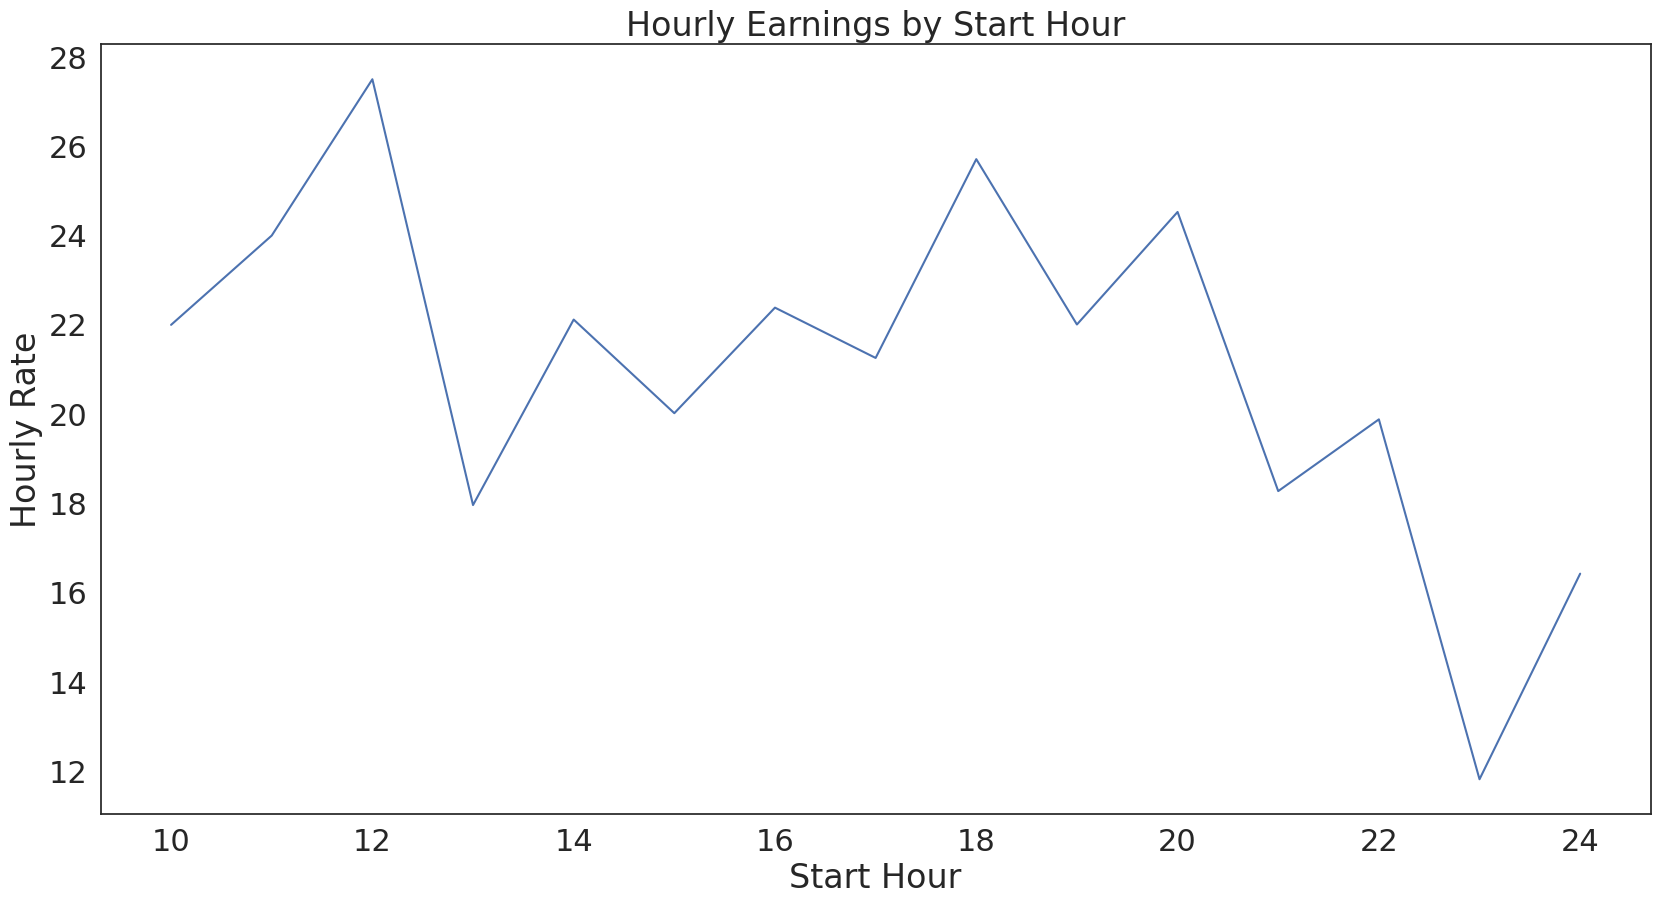

In [566]:
# AVERAGE HOURLY RATE BY HOUR OF DAY #
tempDF_A = sheets_result.copy()
tempDF_A = tempDF_A.groupby(["Date", "Day of Week", "Start Hour"]).agg({"Total" : "sum"})
tempDF_B = tempDF_A.copy()
tempDF_B = tempDF_B.groupby(["Start Hour"]).agg({"Total" : "mean"})
fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Hourly Rate')
sns.lineplot(tempDF_B, legend = False).set(title='Hourly Earnings by Start Hour')
plt.show()
plt.close()

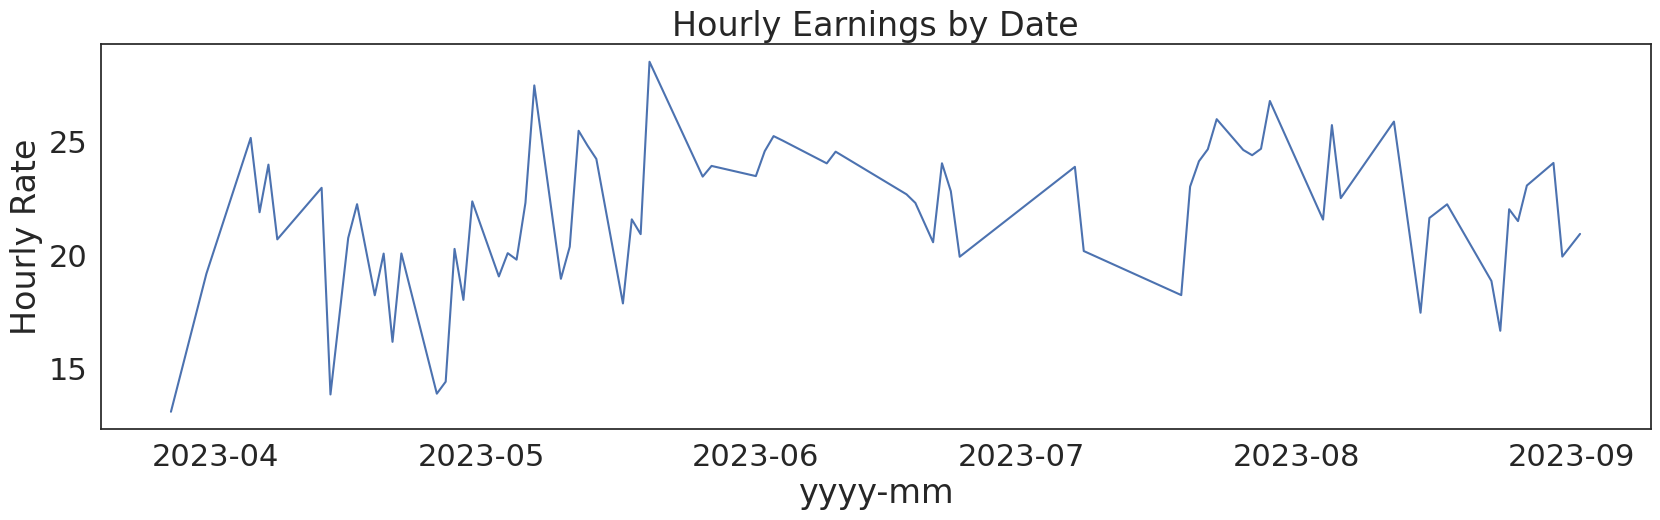

In [567]:
plotDF = sheets_DaysDF[["Date", "HourlyRate"]].copy()
plotDF.index = plotDF['Date']
del plotDF['Date']
fig = plt.subplots(figsize=(20, 5))
plt.ylabel('Hourly Rate')
plt.xlabel('yyyy-mm')
sns.lineplot(plotDF, legend = False).set(title='Hourly Earnings by Date')
plt.show()
plt.close()

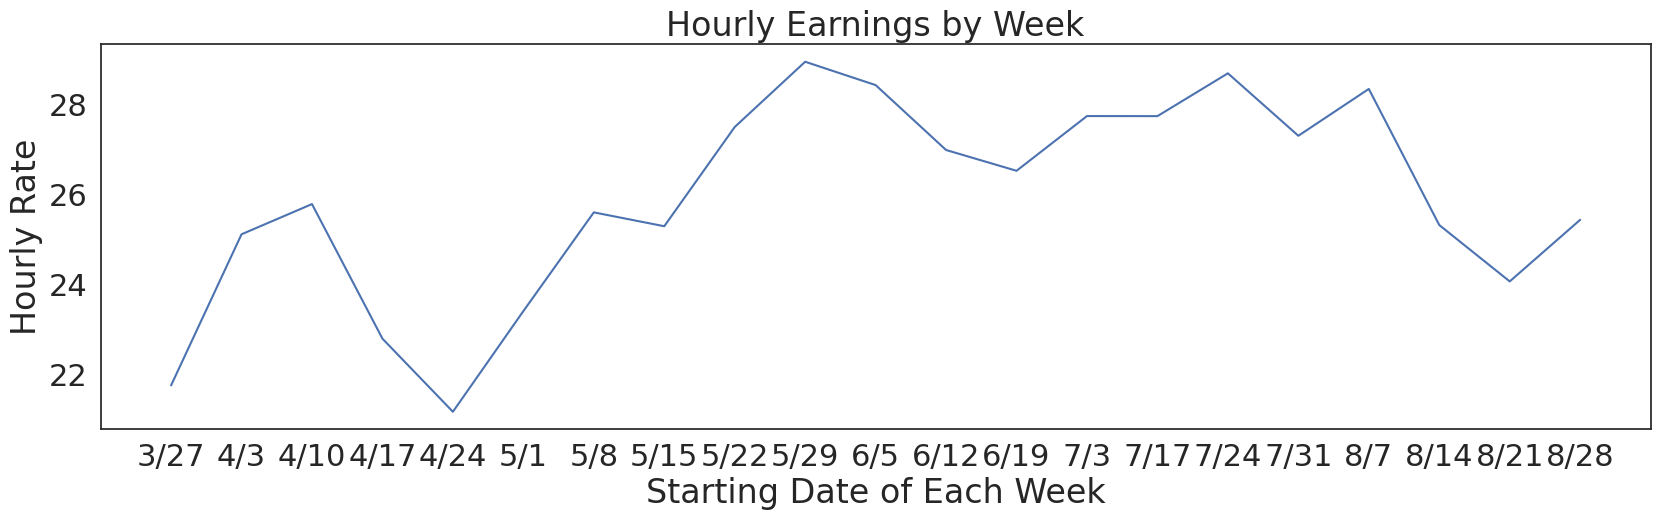

In [568]:
# Weekly avg is higher than daily, weekly includes pay adjustments

plotDF = sheets_WeeksDF[["Start Date", "HourlyRate"]].copy()
plotDF.index = plotDF['Start Date']
del plotDF['Start Date']
fig = plt.subplots(figsize=(20, 5))
plt.ylabel('Hourly Rate')
plt.xlabel('Starting Date of Each Week')
sns.lineplot(plotDF, legend = False).set(title='Hourly Earnings by Week')
plt.show()
plt.close()

#x axis ticks too close together, but overall trends visible

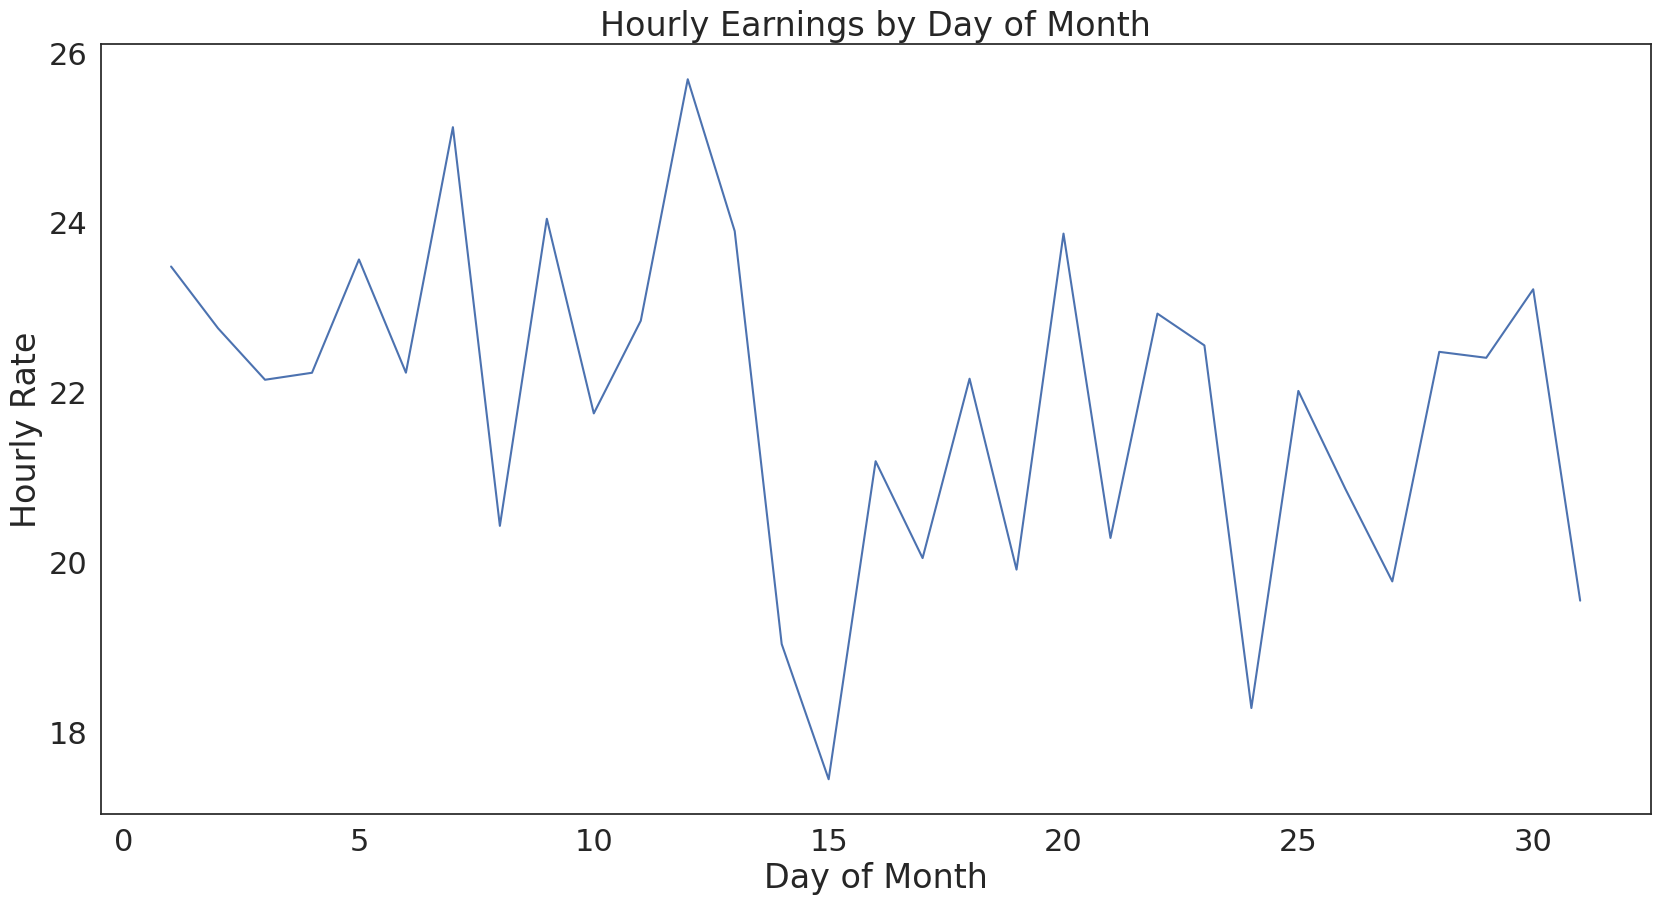

In [569]:
tempDF = sheets_DaysDF.copy()
tempDF = tempDF.groupby(["Day of Month"]).agg({"HourlyRate": 'mean'})
fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Hourly Rate')
sns.lineplot(tempDF, legend = False).set(title='Hourly Earnings by Day of Month')
plt.show()

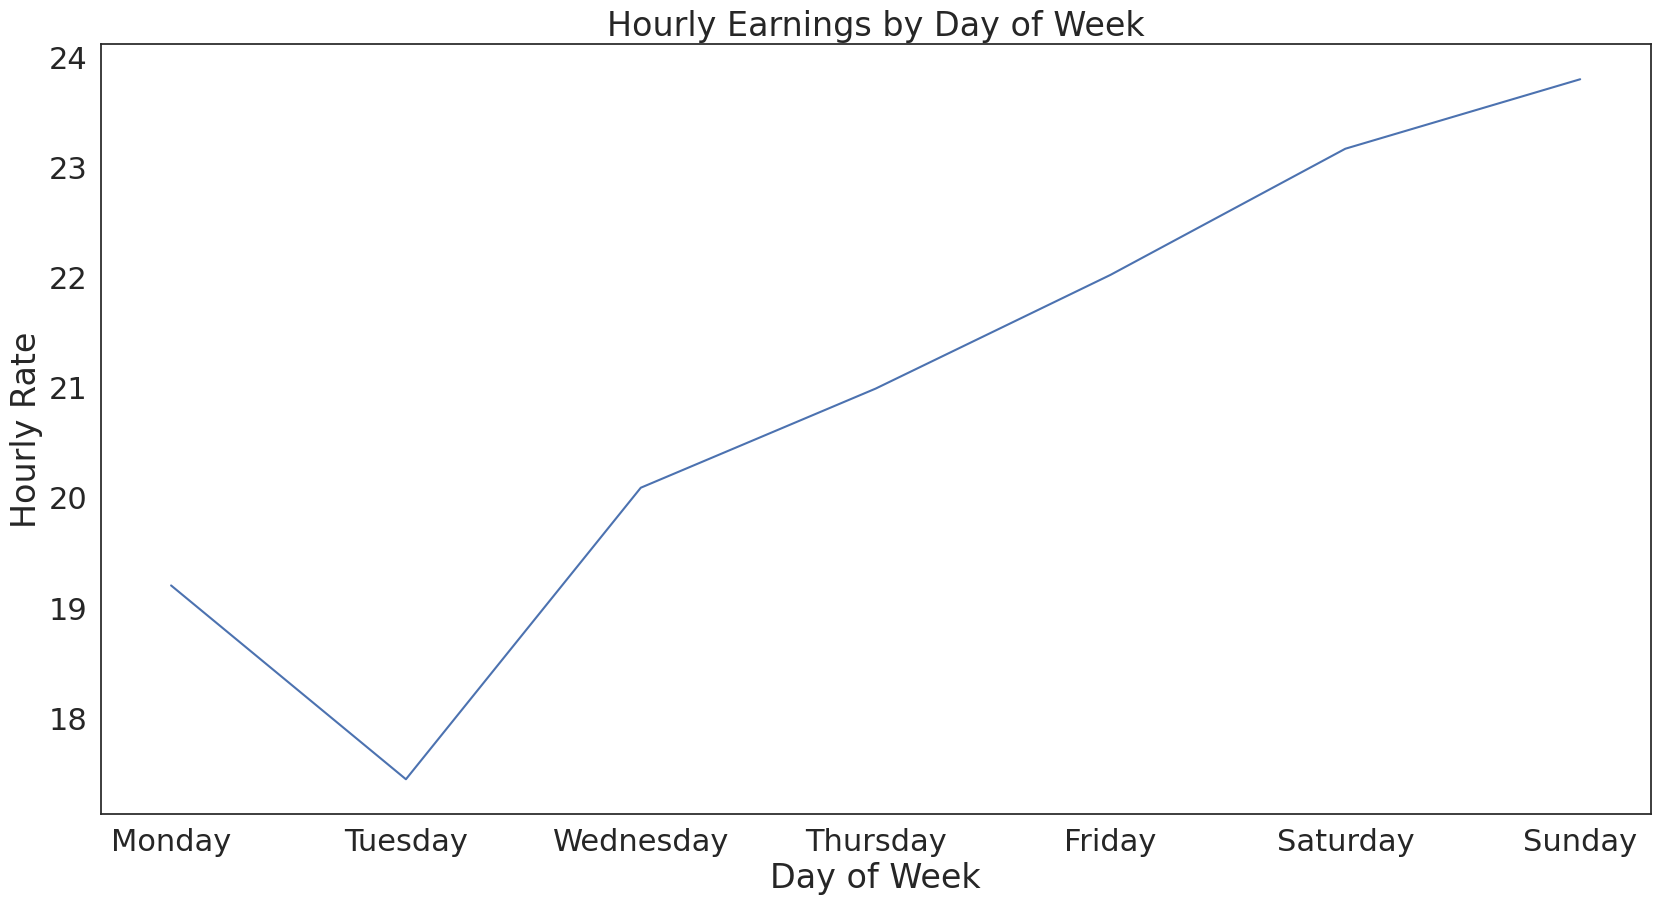

In [570]:
tempDF = sheets_DaysDF.copy()
tempDF = tempDF.groupby(["Day of Week"]).agg({"HourlyRate": 'mean'})
tempDF = tempDF.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Hourly Rate')
sns.lineplot(tempDF, legend = False).set(title='Hourly Earnings by Day of Week')
plt.show()

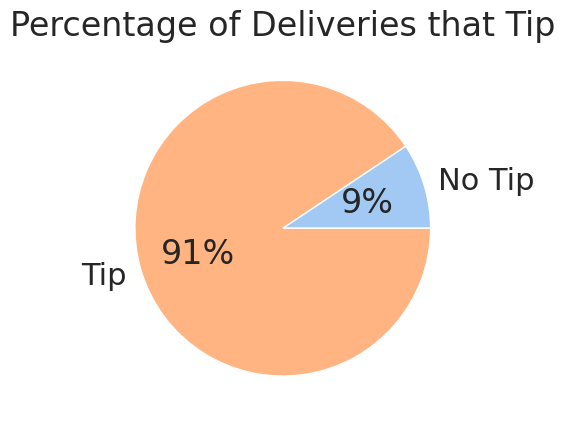

In [571]:
data0 = [numUntipped, numTipped]
labels0 = ['No Tip', 'Tip']
colors = sns.color_palette('pastel')[0:5]
plt.pie(data0, labels = labels0, colors = colors, autopct='%.0f%%')
plt.title('Percentage of Deliveries that Tip')
plt.show()

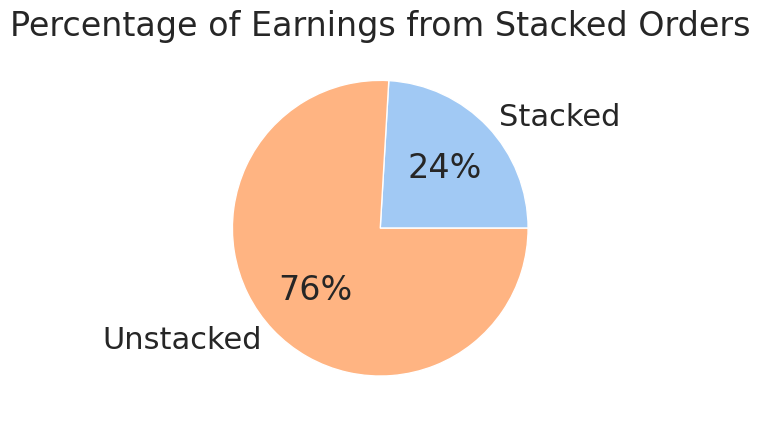

In [572]:
tempDF = sheets_result.copy()
tempDF1 = tempDF[tempDF["Stacked"] == '']
tempDF2 = tempDF[tempDF["Stacked"] != '']
stackedSum = tempDF2["Total"].sum()
unstackedSum = tempDF1["Total"].sum()

data0 = [stackedSum, unstackedSum]
labels0 = ['Stacked', 'Unstacked']
colors = sns.color_palette('pastel')[0:5]
plt.pie(data0, labels = labels0, colors = colors, autopct='%.0f%%')
plt.title('Percentage of Earnings from Stacked Orders')
plt.show()

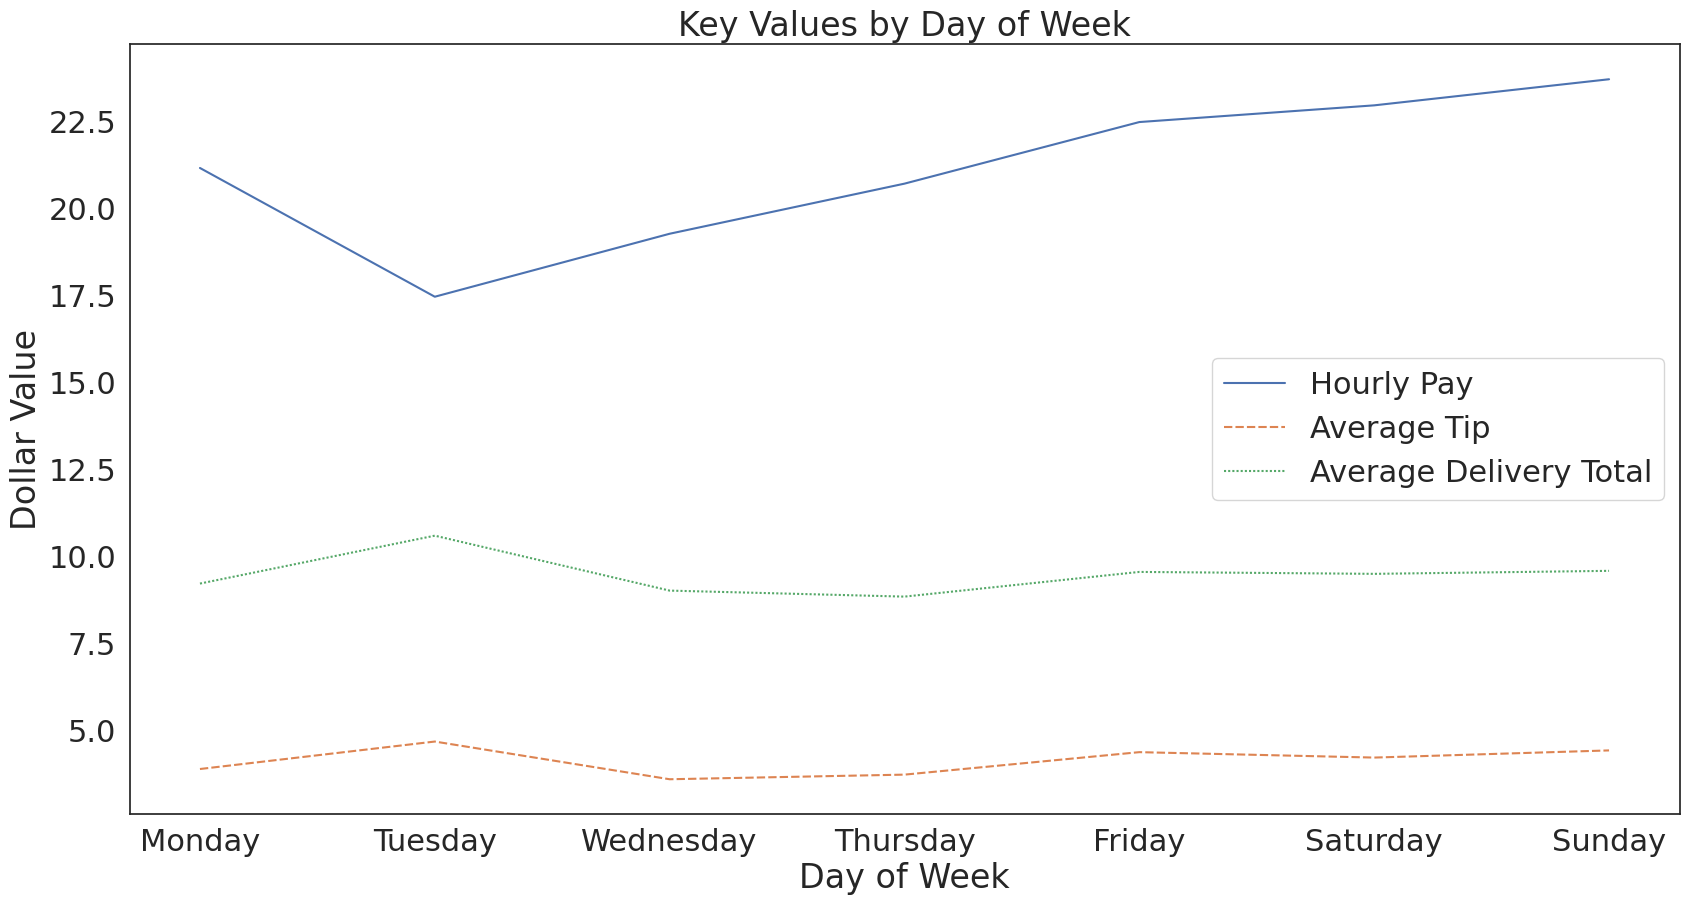

In [612]:
plotDF = DayOfWeekDF[["$/hr", "Avg Delivery Tip", "Avg Delivery Total"]].copy()
plotDF = plotDF.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plotDF = plotDF.rename(columns={"$/hr": "Hourly Pay", 
                                "Avg Delivery Tip": "Average Tip", 
                                "Avg Delivery Total": "Average Delivery Total"})

fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Dollar Value')
sns.lineplot(plotDF).set(title='Key Values by Day of Week')
plt.show()
plt.close()

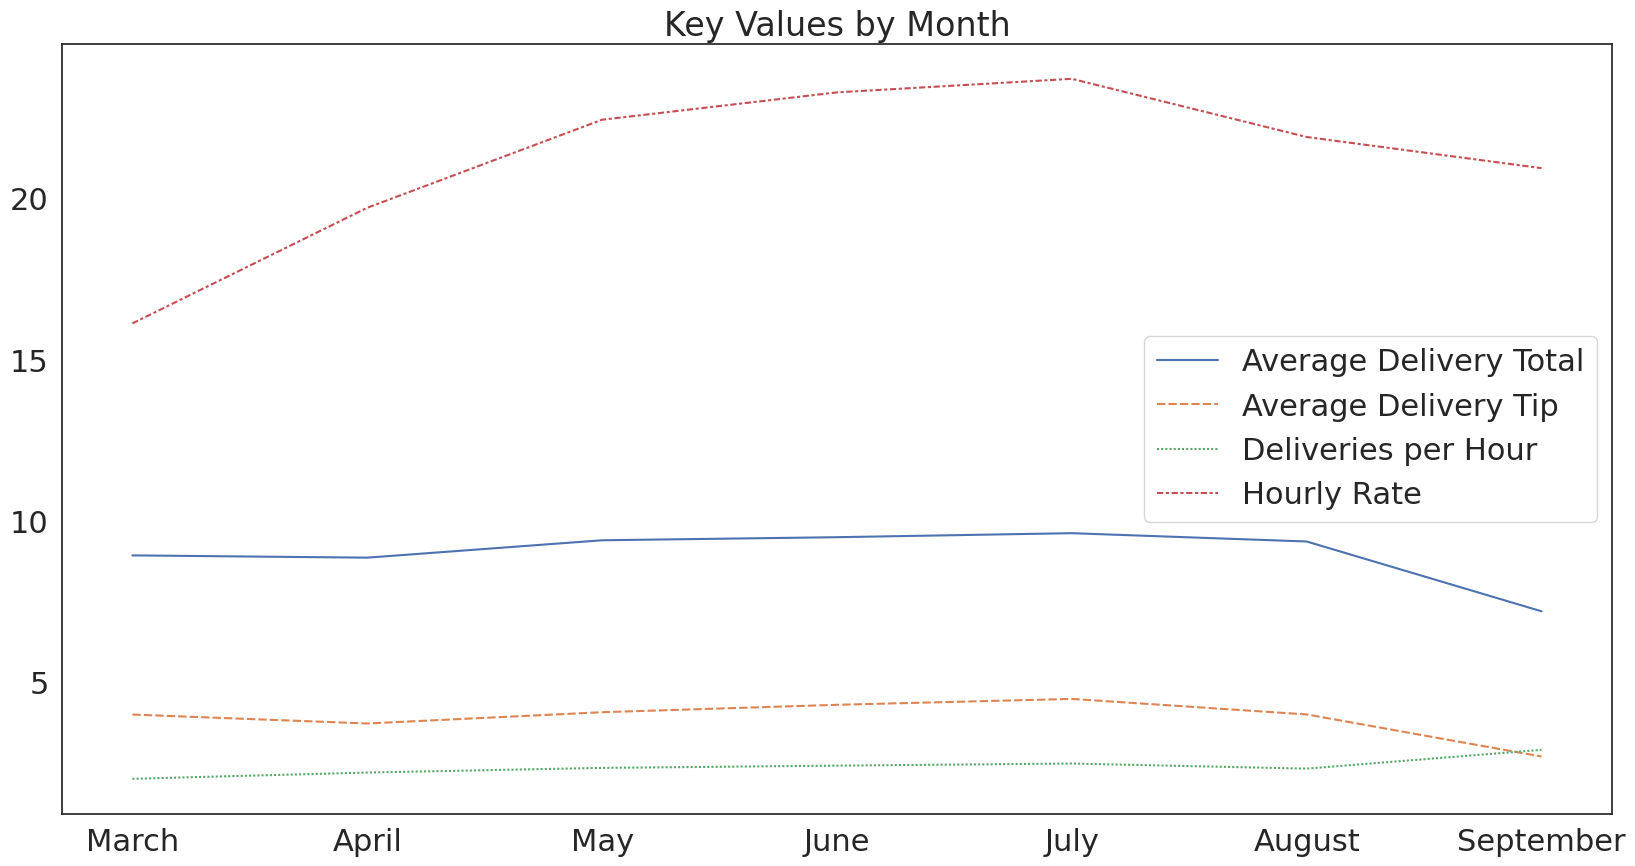

In [613]:
tempDF = sheets_DaysDF.copy()
tempDF["Month"] = tempDF["Date"].dt.month
tempDF = tempDF.groupby(["Month"]).agg({"Total": [np.mean, np.sum],
                                        "Tip": [np.mean, np.sum],
                                       "Active": [np.mean, np.sum],
                                       "Dash": [np.mean, np.sum],
                                       "Deliveries": [np.mean, np.sum],
                                       "HourlyRate": [np.mean],
                                       "ActiveMileage": [np.mean, np.sum],
                                       # "Total Mileage": [np.mean, np.sum],
                                       "Est Adj": [np.mean, np.sum]})


#So we have average daily total, monthly total, 
#average daily tip, monthly total tip
#average active time, total active time
#average shift time, total shift time
#average daily deliveries, total deliveries
#avg monthly hourly rate
#avg and total active mileage
#avg and total est adj


tempDF1 = tempDF.copy()
tempDF1["Average Delivery Total"] = tempDF["Total"]["sum"] / tempDF["Deliveries"]["sum"]
tempDF1["Average Delivery Tip"] = tempDF["Tip"]["sum"] / tempDF["Deliveries"]["sum"]
tempDF1["Deliveries per Hour"] = tempDF["Deliveries"]["sum"] / tempDF["Dash"]["sum"]
#Not sure how to select a multindex, can't do [["hourlyr"]]
#tempDF1[tempDF1.columns[10]] THIS IS SELECTS THE HOURLY RATE COLUMN, DO WE JUST ADD A NEW COLUMN WITH THOSE VALUES?
#We do for now
tempDF1["Hourly Rate"] = tempDF1[tempDF1.columns[10]]
tempDF1 = tempDF1[["Average Delivery Total", "Average Delivery Tip", "Deliveries per Hour", "Hourly Rate"]]

#This is lazy, should either get dt.month name somehow, check datetime options
#or func to convert num to string, dont hardcode
#tempDF1 = tempDF1.reindex(["March", "April", "May", "June", "July", "August"])
new_index = ["March", "April", "May", "June", "July", "August", "September"]
tempDF1 = tempDF1.set_index(pd.Series(new_index))

fig = plt.subplots(figsize=(20, 10))
sns.lineplot(tempDF1).set(title='Key Values by Month')
plt.show()

In [573]:
# UNDER CONSTRUCTION #

In [574]:
sheets_WeeksDF.tail()

,Dates,Base,Tip,Adj pay,Other,Pre Total,Total,Active,Dash,Deliveries,Total Mileage,Version,WeekID,Start Date,End Date,pretotalactiveratio,HourlyRate,ActiveMileage,Est Adj
17,8/7 - 8/13,149.50,109.50,28.66,0.00,259.00,287.66,7.62,10.15,26,141,3,19,8/7,8/13,33.99,28.340887,108.0,24.380
18,8/14 - 8/20,137.75,108.00,47.88,0.00,245.75,293.63,8.20,11.60,28,137,3,20,8/14,8/20,29.97,25.312931,95.1,42.184
19,8/21 - 8/27,498.75,394.65,153.45,19.43,893.40,1066.28,28.77,44.32,101,537,3,21,8/21,8/27,31.05,24.058664,331.9,131.956
20,8/28 - 9/3,220.25,138.75,50.41,0.00,359.00,409.41,11.37,16.10,36,247,3,22,8/28,9/3,31.57,25.429193,168.9,41.836
21,TOTALS:,6597.50,5150.01,1932.91,52.18,11747.51,13732.60,373.78,539.25,1260,3780,-,,NaN,NaN,31.43,25.466110,NaN,NaN


In [575]:
sheets_DaysDF.tail()

,Date,Total,Base,Tip,Start (24),End (24),Active,Dash,Offers,Deliveries,...,Mileage End,Total Mileage,Version,Pauses,WeekID,Day of Week,Day of Month,HourlyRate,ActiveMileage,Est Adj
69,2023-08-26,202.50,100.50,102.00,13:59,23:24,6.00,9.42,23,24,...,72568,105,3,"(5:22pm, 5:34pm)(10:14pm, 10:31pm)",21,Saturday,26,21.496815,61.6,28.444
70,2023-08-27,132.65,73.75,58.90,16:07,21:52,3.80,5.75,14,15,...,72663,73,3,"(7:50pm, 8:11pm)",21,Sunday,27,23.069565,48.9,11.276
71,2023-08-30,213.00,133.50,79.50,10:21,23:12,6.40,8.85,18,19,...,72929,152,3,"(12:16pm, 1:01pm)(2:45pm, 5:59pm)",22,Wednesday,30,24.067797,110.8,19.372
72,2023-08-31,110.00,64.25,45.75,13:43,19:15,3.53,5.52,12,12,...,73018,75,3,0,22,Thursday,31,19.927536,44.0,14.250
73,2023-09-02,36.00,22.50,13.50,18:04,19:48,1.43,1.72,4,5,...,73044,20,3,0,22,Saturday,2,20.930233,14.1,8.034


In [576]:
sheets_result.tail()

,ID,Date,Restaurant Name,Total,Base,Tip,Peak Bonus,Stacked,Version,Day of Week,Start Time,Distance,End Time,Duration,Start Hour,Stack Encoding,Est Adj
1255,1257,2023-09-02,Los Tacos,6.50,3.50,3.0,0.0,,3,Saturday,6:28:00 PM,2.1,6:47:00 PM,19.0,18.0,1.0,2.914
1256,1258,2023-09-02,Wings-N-Things,8.25,3.75,4.5,0.0,1259,3,Saturday,7:18:00 PM,1.7,7:47:00 PM,14.5,19.0,2.0,1.178
1257,1259,2023-09-02,Jack in the Box,3.75,3.75,0.0,0.0,1258,3,Saturday,7:18:00 PM,1.7,7:47:00 PM,14.5,19.0,2.0,1.178
1258,1260,2023-09-02,El Pollo Loco,11.25,5.25,6.0,0.0,,3,Saturday,6:54:00 PM,3.5,7:18:00 PM,24.0,18.0,1.0,3.140
1259,1261,2023-09-02,Chick-fil-A,6.25,6.25,0.0,0.0,,3,Saturday,6:05:00 PM,5.1,6:20:00 PM,15.0,18.0,1.0,-0.016


In [577]:
tempDF_A = sheets_result.copy()
tempDF_A = tempDF_A.groupby(["Date", "Day of Week", "Start Hour"]).agg({"Total" : "sum"})
print(tempDF_A.to_markdown())


|                                                       |   Total |
|:------------------------------------------------------|--------:|
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 13.0)    |   19.94 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 14.0)    |    9.75 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 15.0)    |   22.25 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 16.0)    |   16.75 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 17.0)    |   25.75 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 18.0)    |   23.5  |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 19.0)    |   29.25 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 20.0)    |   44.25 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 24.0)    |   23.25 |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday', 13.0)  |    7.25 |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday', 14.0)  |   25.75 |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday', 15.0)  |   24.5  |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday',

In [578]:
tempDF_B = tempDF_A.copy()
tempDF_B = tempDF_B.groupby(["Start Hour"]).agg({"Total" : "mean"})
print(tempDF_B.to_markdown())

|   Start Hour |   Total |
|-------------:|--------:|
|           10 | 22      |
|           11 | 24      |
|           12 | 27.5    |
|           13 | 17.965  |
|           14 | 22.1188 |
|           15 | 20.0222 |
|           16 | 22.3856 |
|           17 | 21.2592 |
|           18 | 25.7107 |
|           19 | 22.0082 |
|           20 | 24.5282 |
|           21 | 18.2774 |
|           22 | 19.8836 |
|           23 | 11.825  |
|           24 | 16.4286 |


In [603]:

#sheets_DaysDF.tail()
#sheets_WeeksDF.tail()

#Daily and Weekly earnings rate, visualized
#base to tip bar chart by day of week
plotDF = sheets_DaysDF[["Date", "HourlyRate"]].copy()
#plotDF = plotDF.tail(30)
plotDF.index = plotDF['Date']
del plotDF['Date']
plotDF


,HourlyRate
Date,
2023-03-27,13.068182
2023-03-31,19.171429
2023-04-05,25.174825
2023-04-06,21.888646
2023-04-07,23.992727
...,...
2023-08-26,21.496815
2023-08-27,23.069565
2023-08-30,24.067797


In [580]:
#https://builtin.com/data-science/time-series-python#


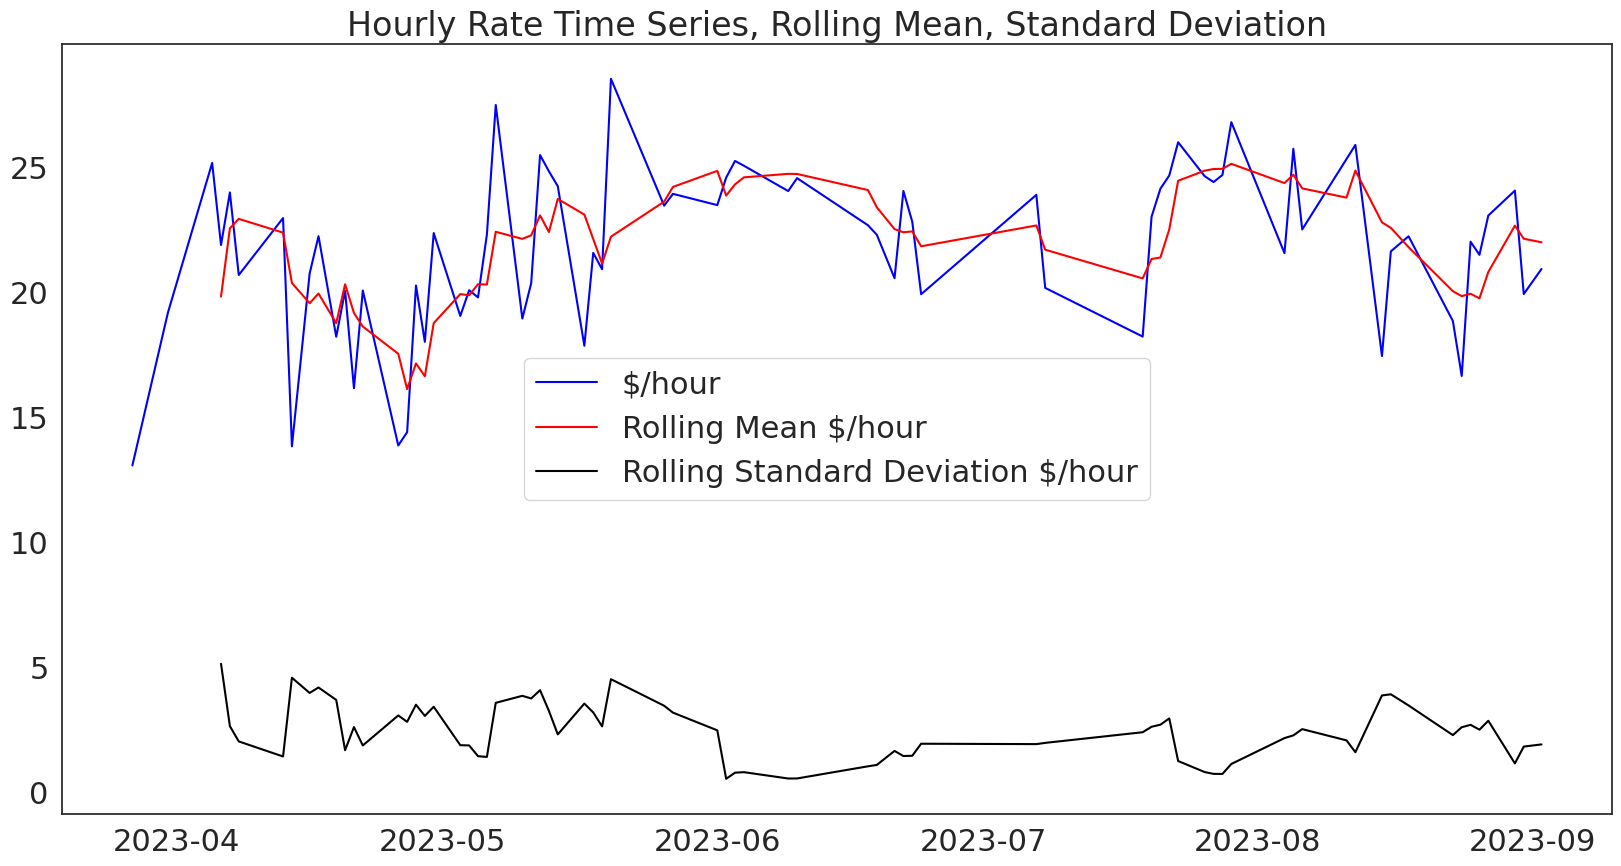

In [581]:
rolling_mean = plotDF.rolling(4).mean()
rolling_std = plotDF.rolling(4).std()

fig = plt.subplots(figsize=(20, 10))

plt.plot(plotDF, color="blue",label="$/hour")
plt.plot(rolling_mean, color="red", label="Rolling Mean $/hour")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation $/hour")
plt.title("Hourly Rate Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()
plt.close()

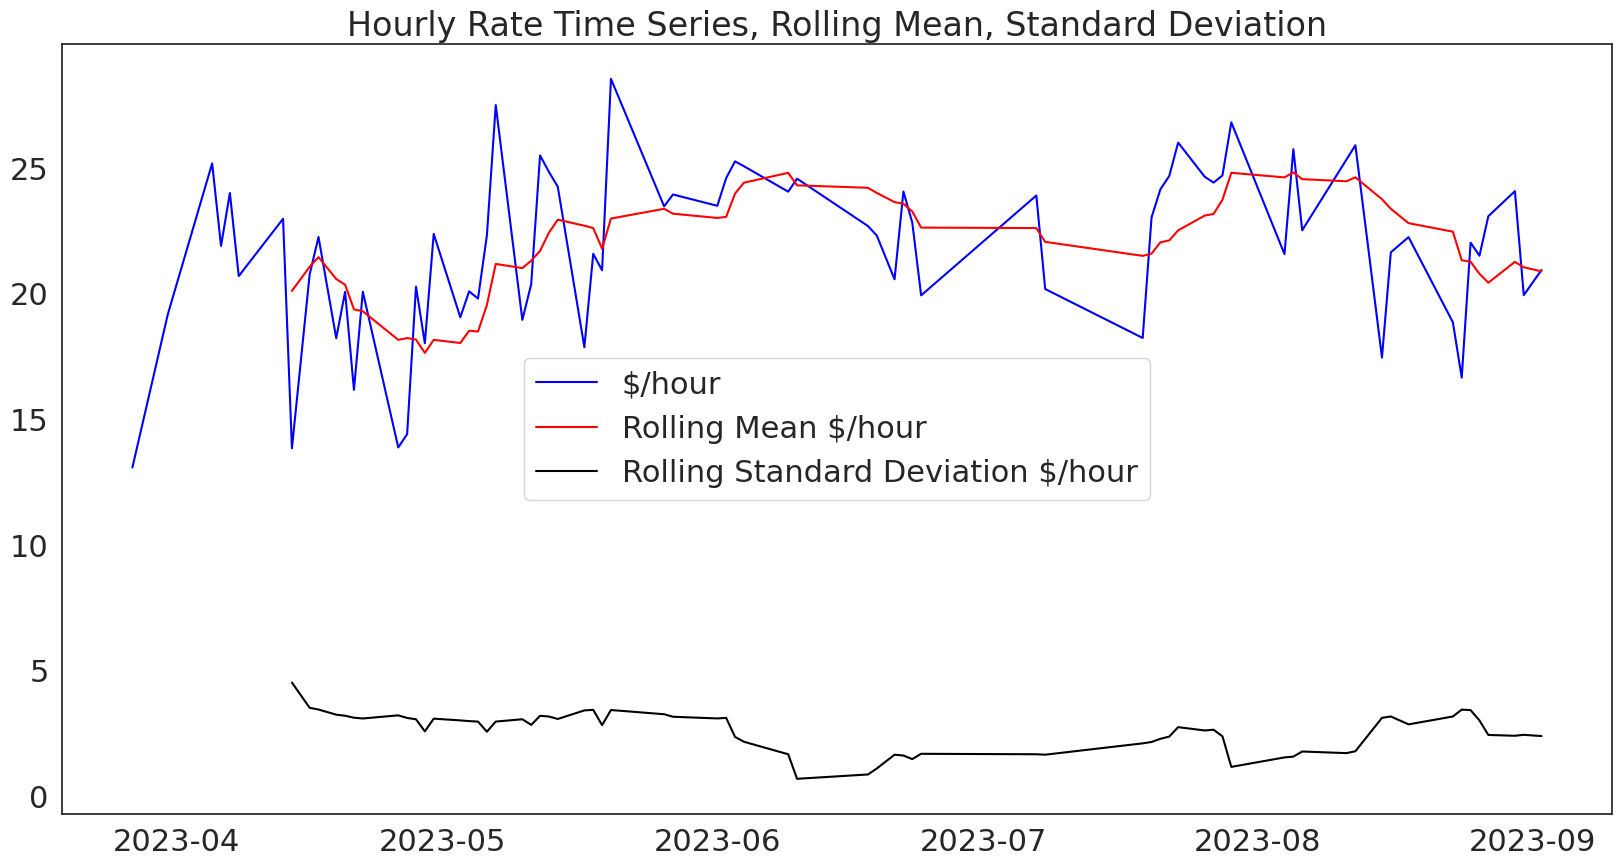

In [582]:
rolling_mean = plotDF.rolling(8).mean()
rolling_std = plotDF.rolling(8).std()

fig = plt.subplots(figsize=(20, 10))

plt.plot(plotDF, color="blue",label="$/hour")
plt.plot(rolling_mean, color="red", label="Rolling Mean $/hour")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation $/hour")
plt.title("Hourly Rate Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()
plt.close()

In [583]:
#plt.close() 
from statsmodels.tsa.stattools import adfuller


In [584]:
adft = adfuller(plotDF,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -4.328438              Test Statistics
1   0.000396                      p-value
2   1.000000             No. of lags used
3  72.000000  Number of observations used
4  -3.524624          critical value (1%)
5  -2.902607          critical value (5%)
6  -2.588679         critical value (10%)


In [585]:
autocorrelation_lag1 = plotDF['HourlyRate'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = plotDF['HourlyRate'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = plotDF['HourlyRate'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = plotDF['HourlyRate'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.33016114217323983
Three Month Lag:  0.25934942179678516
Six Month Lag:  0.12535967496684428
Nine Month Lag:  0.106224524946374


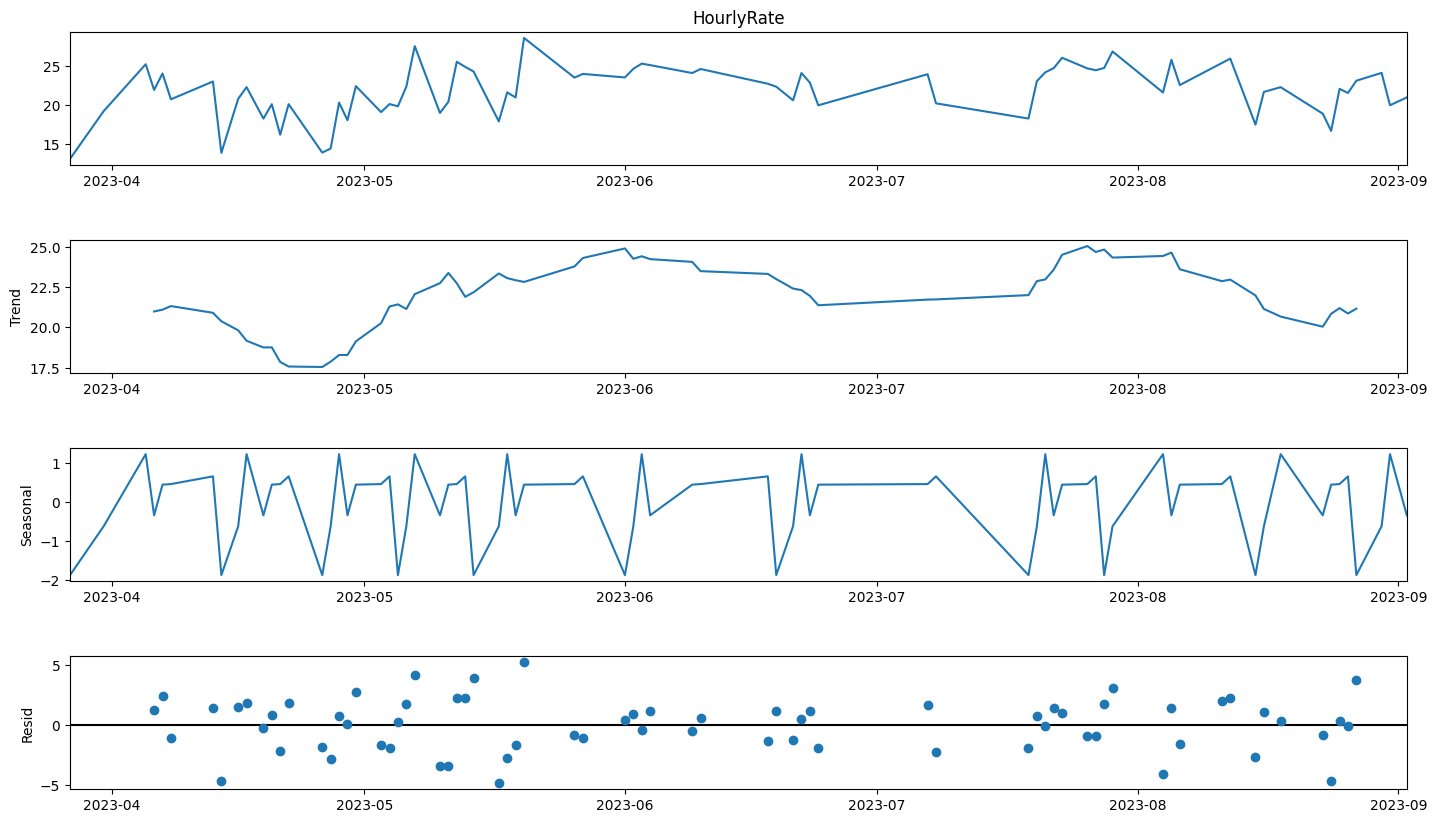

<Figure size 2000x1000 with 0 Axes>

In [607]:
from statsmodels.tsa.seasonal import seasonal_decompose
#fig = plt.subplots(figsize=(20, 10))

decompose = seasonal_decompose(plotDF['HourlyRate'],model='additive', period=7)

#decompose.plot()

fig = decompose.plot()
#plt.figure(figsize=(20,10))
fig.set_size_inches((16, 9))
#decompose.show()
plt.show()
plt.close()
#decompose.close()

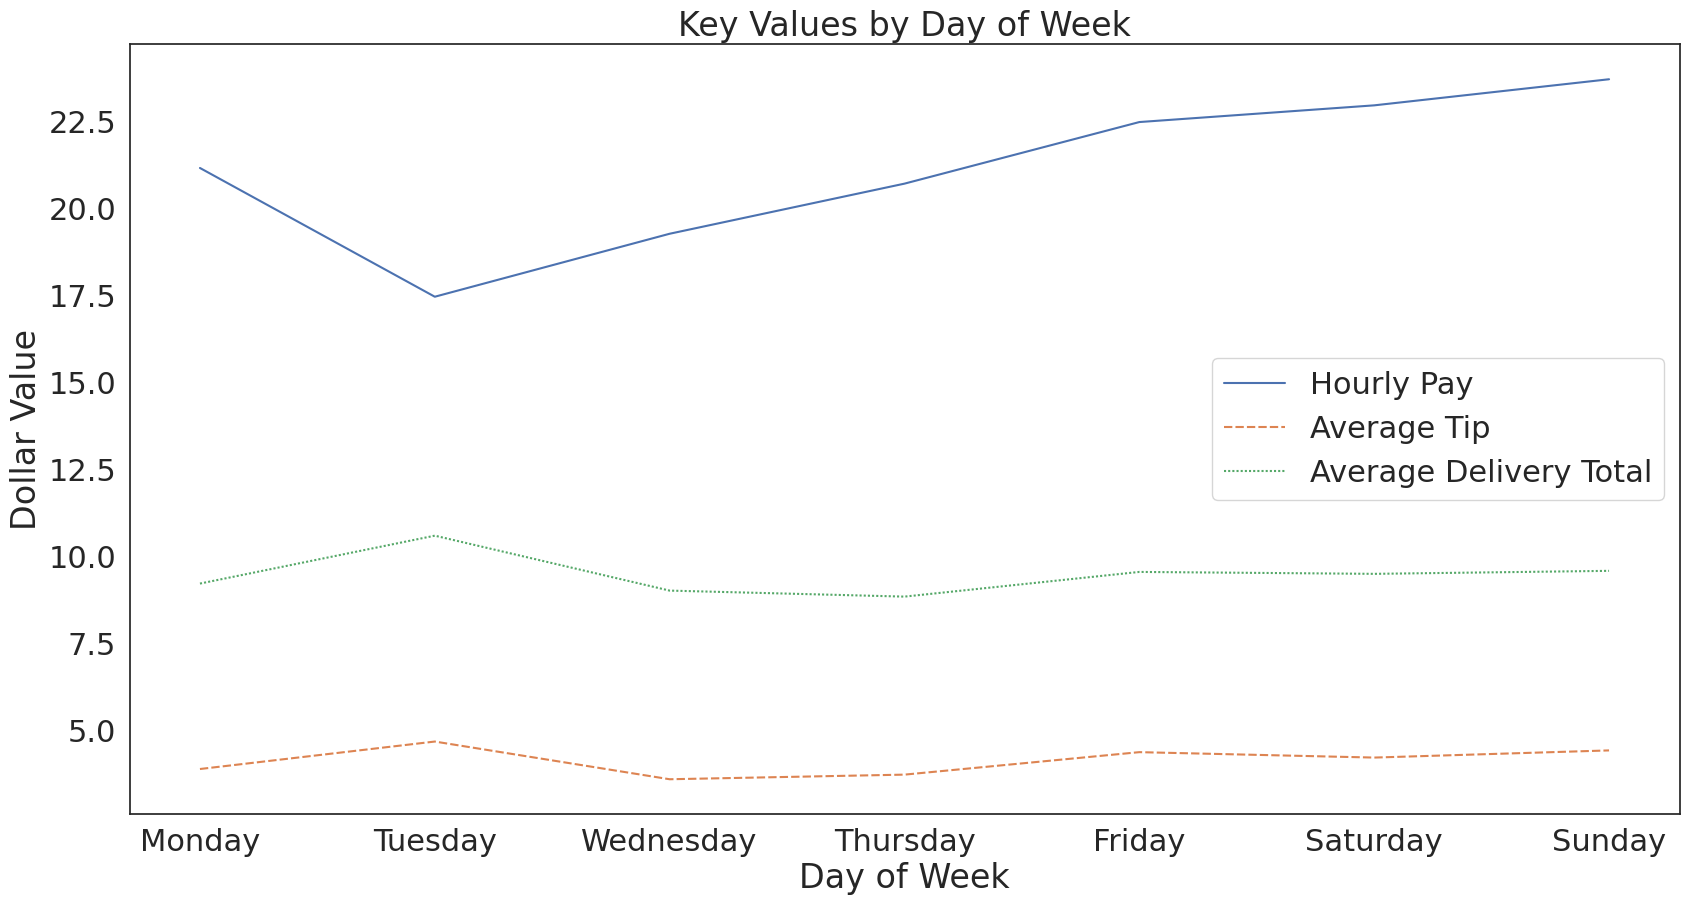

In [589]:
tempDF = restaurantsDF.sort_values(by=["Sum Total"], ascending=False).copy()
tempDF = tempDF.head()
tempDF = tempDF[["Sum Total"]]
overallTotal = sheets_WeeksDF.iloc[-1]["Total"]
leaderTotal = tempDF[["Sum Total"]].sum()
noLeaderTotal = overallTotal - leaderTotal
#tempDF.loc[len(tempDF.index)] = ["Others", noLeaderTotal]
s = noLeaderTotal
s.name = "All Others"
tempDF = tempDF.append(s)
tempDF

/tmp/ipykernel_10242/913864327.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tempDF = tempDF.append(s)


,Sum Total
Restaurant Name,
Chick-fil-A,1342.39
Taco Bell,718.37
McDonald's,624.17
Dave's Hot Chicken,619.00
Chipotle,489.92
All Others,9938.75


In [590]:
overallContribution = []
for index, row in tempDF.iterrows():
    x = round(row["Sum Total"] / overallTotal, 4)*100
    x = '%.2f' % x
    x = str(x) + '% ($' + str(row["Sum Total"]) + ")"
    overallContribution.append(x)
overallContribution

['9.78% ($1342.39)',
 '5.23% ($718.37)',
 '4.55% ($624.17)',
 '4.51% ($619.0)',
 '3.57% ($489.92)',
 '72.37% ($9938.75)']

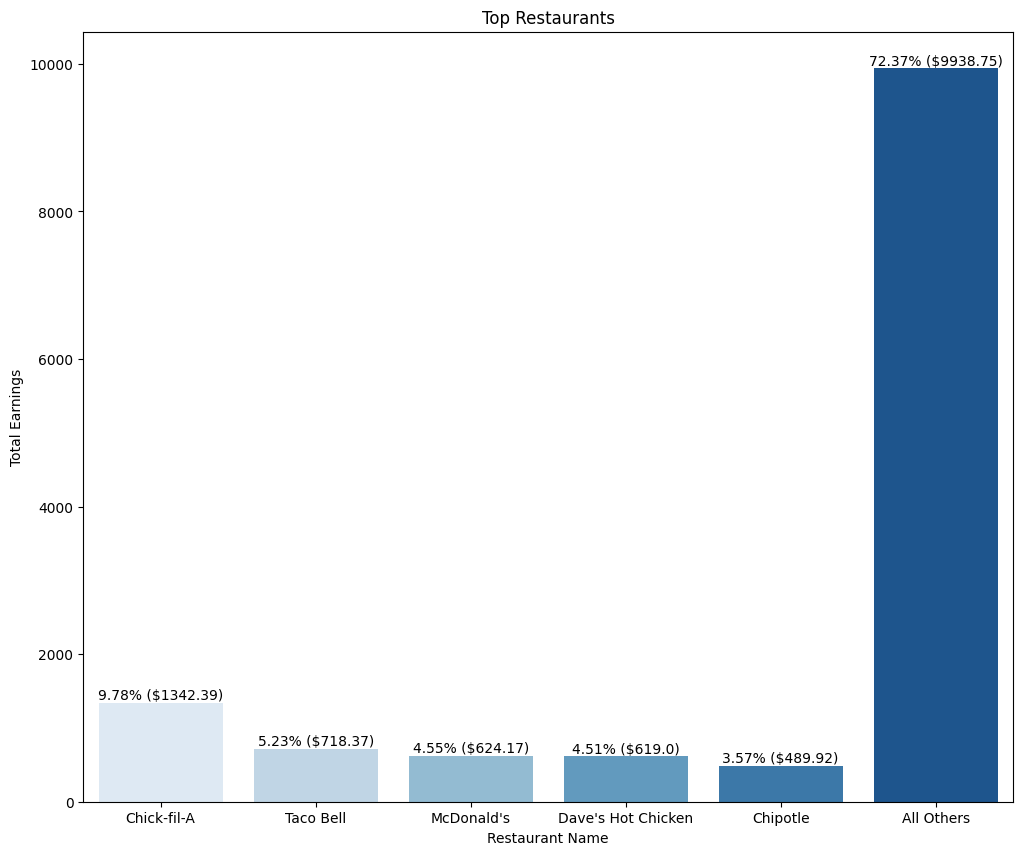

In [591]:
sns.reset_defaults()

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x = tempDF.index,
            y = 'Sum Total',
            data = tempDF,
            palette = "Blues").set(ylabel="Total Earnings", title="Top Restaurants")
#for i in ax.containers:
#    ax.bar_label(i,) 
# Show the plot
#ax.bar_label(ax.containers[0])
for bars in ax.containers:
        ax.bar_label(bars, labels=overallContribution)
plt.show()
plt.close()

In [592]:
tempDF = restaurantsDF.sort_values(by=["Deliveries"], ascending=False).copy()
tempDF = tempDF.head()
tempDF = tempDF[["Deliveries"]]
overallTotal = sheets_WeeksDF.iloc[-1]["Deliveries"]
leaderTotal = tempDF[["Deliveries"]].sum()
noLeaderTotal = overallTotal - leaderTotal
#tempDF.loc[len(tempDF.index)] = ["Others", noLeaderTotal]
s = noLeaderTotal
s.name = "All Others"
tempDF = tempDF.append(s)
tempDF

/tmp/ipykernel_10242/920349414.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tempDF = tempDF.append(s)


,Deliveries
Restaurant Name,
Chick-fil-A,143
Taco Bell,83
McDonald's,81
Dave's Hot Chicken,65
Chipotle,60
All Others,828


In [593]:
overallContribution = []
for index, row in tempDF.iterrows():
    x = round(row["Deliveries"] / overallTotal, 4)*100
    x = '%.2f' % x
    x = str(x) + '% (' + str(row["Deliveries"]) + ')'
    overallContribution.append(x)
overallContribution

['11.35% (143)',
 '6.59% (83)',
 '6.43% (81)',
 '5.16% (65)',
 '4.76% (60)',
 '65.71% (828)']

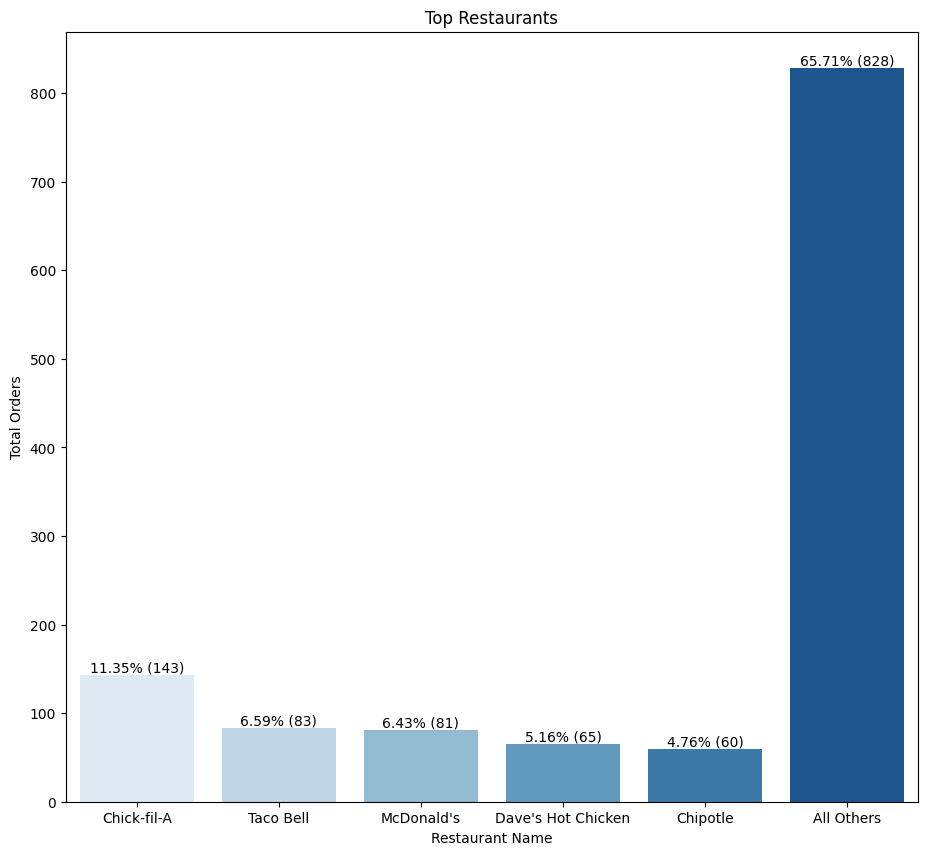

In [594]:
sns.reset_defaults()

fig, ax = plt.subplots(figsize=(11, 10))
sns.barplot(x = tempDF.index,
            y = 'Deliveries',
            data = tempDF,
            palette = "Blues").set(ylabel="Total Orders", title="Top Restaurants")
for bars in ax.containers:
        ax.bar_label(bars, labels=overallContribution)
plt.show()
plt.close()

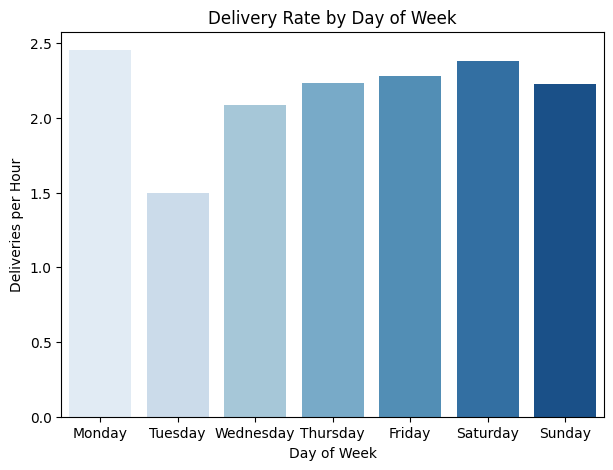

In [595]:
HourlyDelRateDF = sheets_result.groupby(["Date", "Day of Week", "Start Hour"]).agg({"Start Hour": 'size'})
HourlyDelRateDF2 = HourlyDelRateDF.groupby(["Day of Week"]).agg({"Start Hour": "mean"})
HourlyDelRateDF2 = HourlyDelRateDF2.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x = HourlyDelRateDF2.index,
            y = 'Start Hour',
            data = HourlyDelRateDF2,
            palette = "Blues").set(ylabel="Deliveries per Hour", title="Delivery Rate by Day of Week")
#for bars in ax.containers:
#        ax.bar_label(bars, labels=overallContribution)
plt.show()
plt.close()

In [596]:
#sheets_DaysDF.columns
tempDF = sheets_DaysDF.copy()
#newList = []
#tempDF.dtypes
#tempDF.iloc[0]["Date"].month

tempDF["Month"] = tempDF["Date"].dt.month
#tempDF.head()
tempDF = tempDF.groupby(["Month"]).agg({"Total": [np.mean, np.sum],
                                        "Tip": [np.mean, np.sum],
                                       "Active": [np.mean, np.sum],
                                       "Dash": [np.mean, np.sum],
                                       "Deliveries": [np.mean, np.sum],
                                       "HourlyRate": [np.mean],
                                       "ActiveMileage": [np.mean, np.sum],
                                       # "Total Mileage": [np.mean, np.sum],
                                       "Est Adj": [np.mean, np.sum]})
tempDF

#We need to convert - to 0 from Total Mileage values



Total                 Tip             Active              Dash  \
             mean      sum       mean      sum      mean     sum      mean   
Month                                                                        
3       98.250000   196.50  44.000000    88.00  3.345000    6.69  5.475000   
4      122.497647  2082.46  51.468235   874.96  4.121765   70.07  6.275294   
5      207.975000  3327.60  90.100000  1441.60  6.380000  102.08  9.425625   
6      197.030000  2364.36  89.259167  1071.11  6.347500   76.17  8.584167   
7      144.295455  1587.25  67.272727   740.00  4.397273   48.37  6.042727   
8      143.556000  2153.34  61.389333   920.84  4.547333   68.21  6.596000   
9       36.000000    36.00  13.500000    13.50  1.430000    1.43  1.720000   

              Deliveries      HourlyRate ActiveMileage           Est Adj  \
          sum       mean  sum       mean          mean    sum       mean   
Month                                                                      
3       10.95  11.000000   22  16.119805           NaN    0.0        NaN   
4      106.68  13.823529  235  19.703374           NaN    0.0        NaN   
5      150.81  22.125000  354  22.430972     78.700000  157.4  28.858000   
6      103.01  20.750000  249  23.278021     77.375000  928.5  32.791667   
7       66.47  15.000000  165  23.698740     56.009091  616.1  21.171273   
8       98.94  15.333333  230  21.895913     58.540000  878.1  19.588933   
9        1.72   5.000000    5  20.930233     14.100000   14.1   8.034000   

                
           sum  
Month           
3        0.000  
4        0.000  
5       57.716  
6      393.500  
7      232.884  
8      293.834  
9        8.034

In [597]:
#So we have average daily total, monthly total, 
#average daily tip, monthly total tip
#average active time, total active time
#average shift time, total shift time
#average daily deliveries, total deliveries
#avg monthly hourly rate
#avg and total active mileage
#avg and total est adj


#We want to normalize some of this, div by time or by delivery count

#HourlyRate is fine
#Delivery Total average is Total.sum/Deliveries.sum
#Tip Total avg is Tip.sum/Deliveries.sum
#Deliveries/Hour is Deliveries.sum/Dash.sum

#tempDF.iloc[0]["Total"]["mean"]
tempDF1 = tempDF.copy()
tempDF1["Average Delivery Total"] = tempDF["Total"]["sum"] / tempDF["Deliveries"]["sum"]
tempDF1["Average Delivery Tip"] = tempDF["Tip"]["sum"] / tempDF["Deliveries"]["sum"]
tempDF1["Deliveries per Hour"] = tempDF["Deliveries"]["sum"] / tempDF["Dash"]["sum"]
#Not sure how to select a multindex, can't do [["hourlyr"]]
#tempDF1[tempDF1.columns[10]] THIS IS SELECTS THE HOURLY RATE COLUMN, DO WE JUST ADD A NEW COLUMN WITH THOSE VALUES?
#We do for now
tempDF1["Hourly Rate"] = tempDF1[tempDF1.columns[10]]


tempDF1 = tempDF1[["Average Delivery Total", "Average Delivery Tip", "Deliveries per Hour", "Hourly Rate"]]
#tempDF1.dtypes

#This is lazy, should either get dt.month name somehow, check datetime options
#or func to convert num to string, dont hardcode
#tempDF1 = tempDF1.reindex(["March", "April", "May", "June", "July", "August"])
new_index = ["March", "April", "May", "June", "July", "August", "September"]
tempDF1 = tempDF1.set_index(pd.Series(new_index))


tempDF1




,Average Delivery Total,Average Delivery Tip,Deliveries per Hour,Hourly Rate
,,,,
March,8.931818,4.000000,2.009132,16.119805
April,8.861532,3.723234,2.202850,19.703374
May,9.400000,4.072316,2.347324,22.430972
June,9.495422,4.301647,2.417241,23.278021
July,9.619697,4.484848,2.482323,23.698740
August,9.362348,4.003652,2.324641,21.895913
September,7.200000,2.700000,2.906977,20.930233


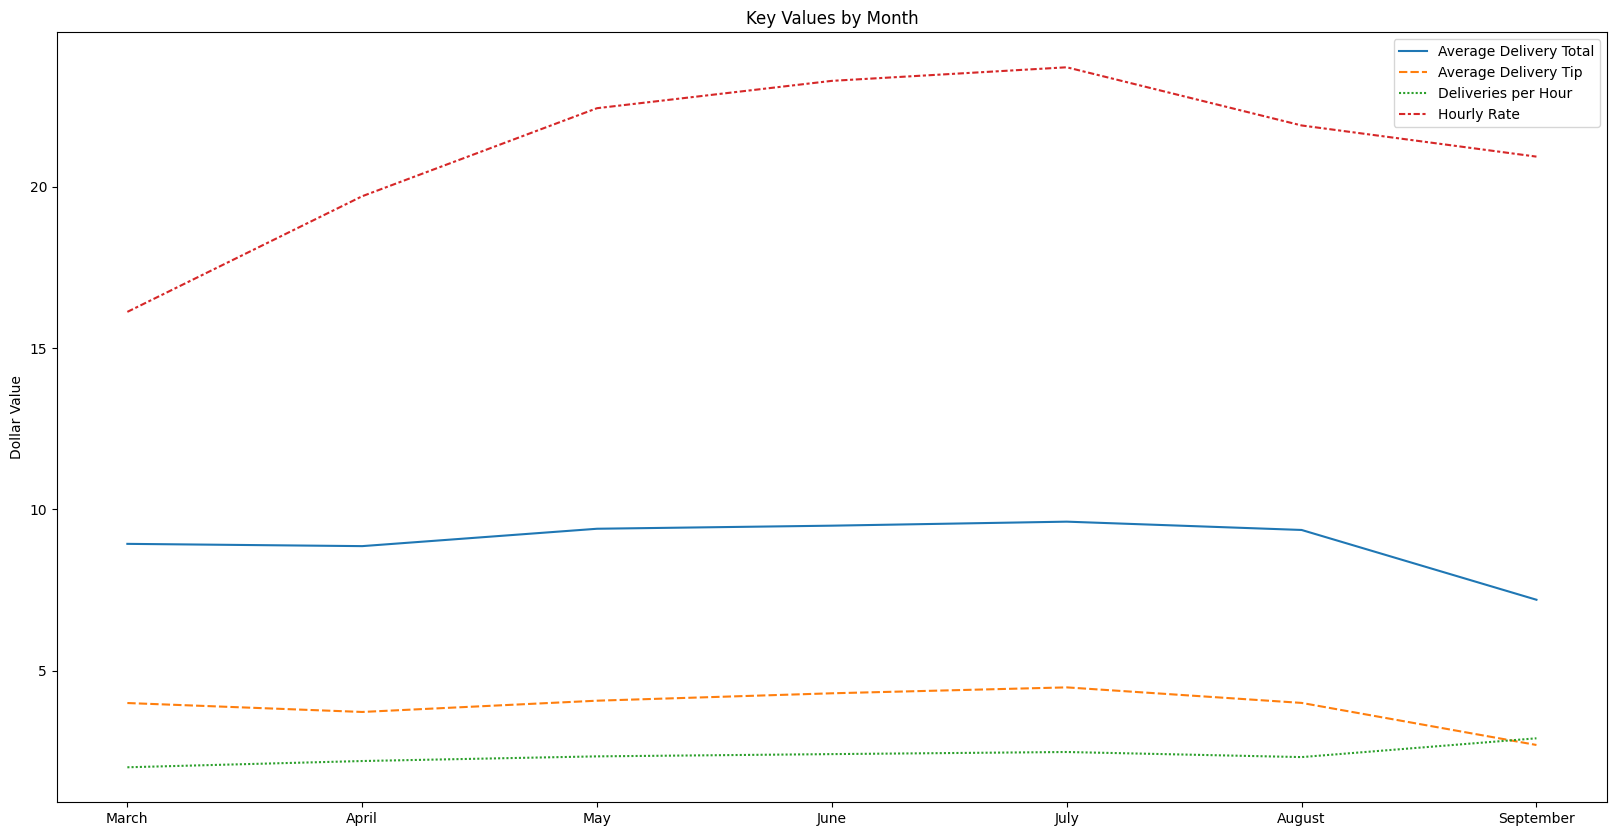

In [598]:


fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Dollar Value')
sns.lineplot(tempDF1).set(title='Key Values by Month')
plt.show()

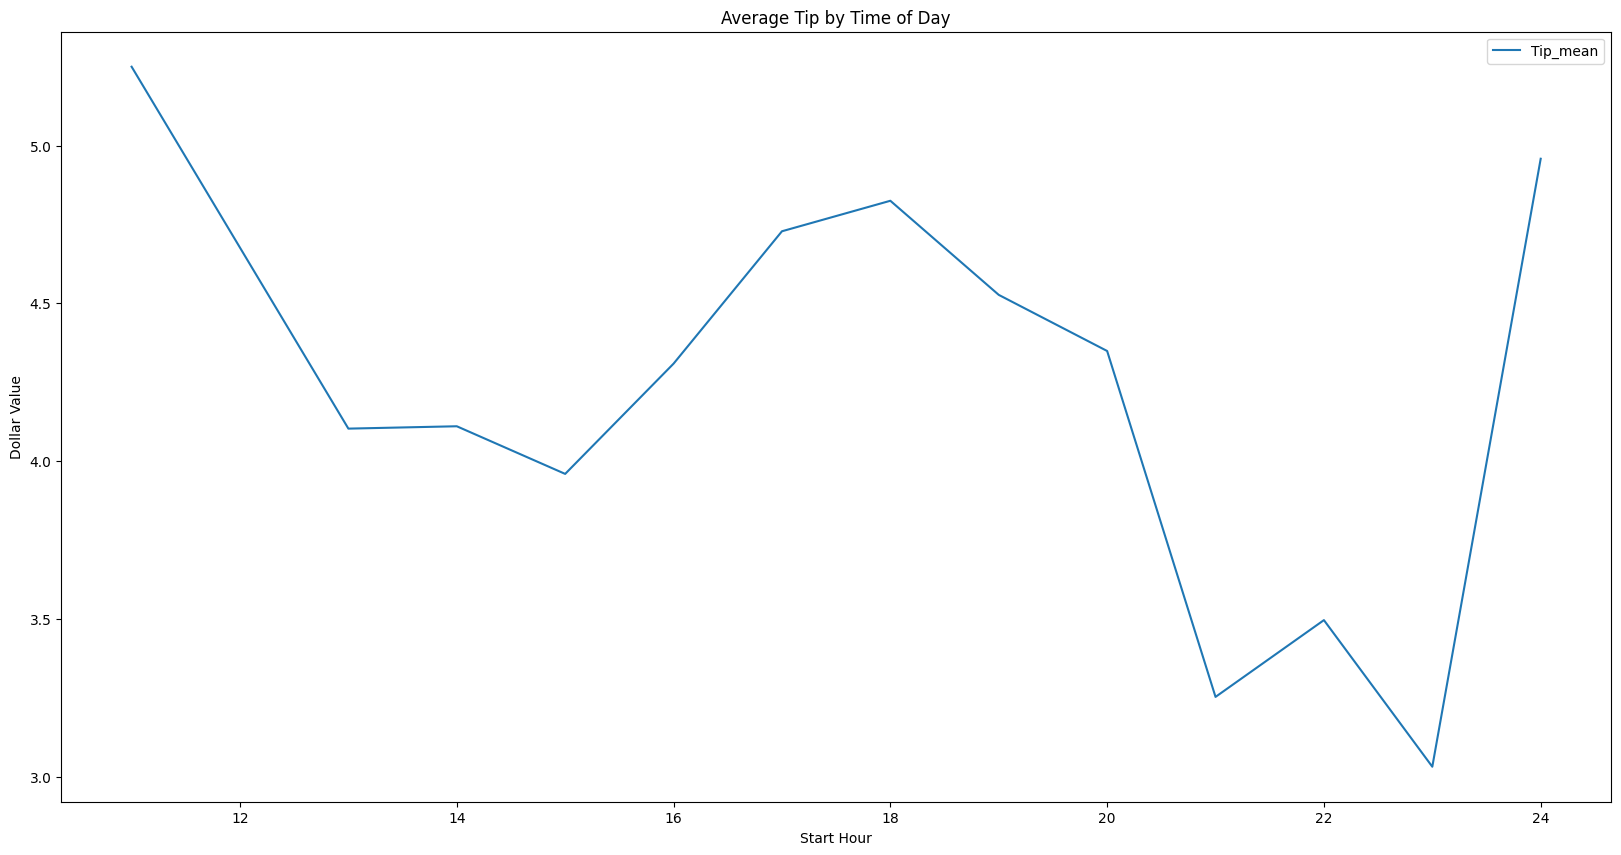

In [599]:
tempDF = sheets_result[sheets_result["Version"]==3].copy()
tempDF0 = tempDF.groupby(["Day of Week", "Start Hour"]).agg({"Total": [np.mean, np.sum],
                                            "Base": [np.mean, np.sum], 
                                            "Tip": [np.mean, np.sum],
                                            "Start Hour": 'size'})
tempDF1 = tempDF.groupby(["Start Hour"]).agg({"Total": [np.mean, np.sum],
                                            "Base": [np.mean, np.sum], 
                                            "Tip": [np.mean, np.sum],
                                            "Start Hour": 'size'})
#tempDF1
#tempDF1 = tempDF1.rename(columns={"$/hr": "Hourly Pay", 
#                                "Avg Delivery Tip": "Average Tip", 
#                                "Avg Delivery Total": "Average Delivery Total"})

#tempDF1.sort_values(by=["Tip"][0])
tempDF1.columns = tempDF1.columns.map('_'.join)
tempDF1 = tempDF1.sort_values(by=["Tip_mean"], ascending=False)
#Dropping the lowest 2 rows because they only include 5 deliveries total
tempDF2 = tempDF1.iloc[:-2]
tempDF2 = tempDF2[["Tip_mean"]]
#tempDF2

fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Dollar Value')
sns.lineplot(tempDF2).set(title='Average Tip by Time of Day')
plt.show()

#So 6pm is the best tip time, and we want to look for higher paying orders then
#Also, midnight has great tips, even though 9, 10, 11 are the worst

In [600]:
tempDF = sheets_result.copy()
tempDF1 = tempDF[tempDF["Base"]==tempDF["Tip"]]
tempDF1.shape
#Okay, 59 orders out of about 1200 isn't exactly a pattern, it appens just under 5% of the time
#Which is neat, but not useful
#Look into other patterns for tipping behavior

(60, 17)

In [601]:
sns.reset_defaults()